In [1]:
# if local use new_torch_env

import os

import numpy as np
from scipy import stats
import pandas as pd
# import seaborn as sns

from collections import Counter

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from xml.etree import ElementTree, ElementInclude

import pickle
from functools import reduce

import iptcinfo3
from iptcinfo3 import IPTCInfo

import detectron2

from utills_output import *

# TODO

- [ ] **gen annotated dfs for all thresholds range(0.1, 0.76, 0.01)**
- [ ] make work for full

In [ ]:
def feature_dist_plots(df, result = 'mean', feature_version = 'mean'): # feature should be all and go inside.. but then you need mean first or it gets messig...

    """Df can be one df with a given threshold. Result can be 'mean' or 'dummy'.
    Feature version can be a model short, eg. 'fasterX101' or retinaR50. 
    It can also be a ensamble indication e.g. mean or median."""
    max_result = 0 # for plotting xticks..
    pub_status = df['custom2'].unique()

    # raw = df[df['custom2'] == 'Raw'][feature]
    # Published

    plt.figure(figsize= [15,15])
    fig_name = f'feature_dist_plots_{result}'

    for i, j in enumerate(pub_status):

        # ratio_list = []
        result_list = []
        feature_list = []

        for f in df.columns[df.columns.str.endswith(feature_version)]:
            
            N = df[df['custom2'] == j][f].shape[0]

            if result == 'mean':
                mean_result = df[df['custom2'] == j][f].mean()
                result_list.append(mean_result)
                plt.xlabel('Mean count of objects cross subsets of images (Raw, Submitted, Published)', fontsize = 14)

                max_result = max(mean_result, max_result)# for plotting xticks..
                ticks_w = 0.2
    

            elif result == 'dummy':
                dummy_result = (df[df['custom2'] == j][f] > 0).mean()
                result_list.append(dummy_result)
                plt.xlabel('non-zero count of objects cross subsets of images (Raw, Submitted, Published)', fontsize = 14)

                max_result = max(dummy_result, max_result)# for plotting xticks..
                ticks_w = 0.05

            feature_list.append(f)
            
                
        plt.title(f'Ensample resutls')

        plt.barh(np.arange(0+(i/4), len(result_list)+(i/4), 1), result_list, height= 0.25, alpha = 0.5, label = f'{j} (N = {N})')
        
    plt.yticks(np.arange(0+(1/4), len(result_list)+(1/4), 1), feature_list, fontsize = 16, label = f'{j} (N = {N})')
    plt.xticks(np.arange(0, max_result + ticks_w, ticks_w))

    plt.legend(fontsize = 14, loc = 'upper right')

    plt.savefig(f'{fig_name}.pdf', bbox_inches="tight")   

    plt.show()

In [ ]:
def jensen_shannon_distance(p, q):
    """
    method to compute the Jenson-Shannon Distance 
    between two probability distributions. 
    From https://medium.com/@sourcedexter/how-to-find-the-similarity-between-two-probability-distributions-using-python-a7546e90a08d
    """

    # convert the vectors into numpy arrays in case that they aren't
    p = np.array(p)
    q = np.array(q)

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (stats.entropy(p, m) + stats.entropy(q, m)) / 2

    # compute the Jensen Shannon Distance
    distance = np.sqrt(divergence)

    return distance

In [ ]:
def open_df(full = False, threshold = 0.3):
    
    path = '/home/simon/Documents/Bodies/data/OD_dataframes'

    if full == True:
        df_name = f'OD_DF_FULL_t{int(threshold*100)}.pkl'

    elif full == False:
        df_name = f'OD_DF_annotated_t{int(threshold*100)}.pkl'

    print(f'loading: {df_name}')

    df_path = os.path.join(path, df_name)

    with open(df_path, 'rb') as file:
        df = pickle.load(file)

    return(df)

In [ ]:
def get_df_dict(full = False):

    df_dict = {}
#-------------------------------
    path = '/home/simon/Documents/Bodies/data/OD_dataframes'

    for root, dirs, files in os.walk(path):

        if full == False:
            ts_list = [file for file in files if file.split('_')[2] == 'annotated']

        elif full == True:
            ts_list = [file for file in files if file.split('_')[2] == 'FULL']
        
        t_range = [float(file.split('_')[-1].split('.')[0].split('t')[1])/100 for file in ts_list]
        t_range = sorted(np.array(t_range))
# ---------------------------------

    for t in t_range:
        df_name = f'df_t{int(t*100)}'
        df_dict[df_name] = open_df(full, t)
        print(f'Done w/ {df_name}', end='\r')

    return(df_dict)

In [ ]:
def get_JSD(feature):
    
    best_corr = 0 # just initial value to beat
    best_JSD = np.inf # just initial value to beat
    best_dict = {'feature':feature}
    for k in df_dict.keys():
        feature_mean = f'{feature}_mean'
        feature_annotated = f'{feature}_annotated'
        if feature_mean in np.array(df_dict[k].columns):
            #print(k, end = ': ')
            pk = df_dict[k][feature_mean] # is there strickly any reason you are not using a sample from the full set?
            qk = df_dict[k][feature_annotated]
            JSD = jensen_shannon_distance(pk, qk)
            corr = np.corrcoef(pk, qk)[0,1]            
            #KLD  = stats.entropy(pk, qk)
            #print(f'{JSD:.3f}')
            if JSD < best_JSD:
                best_JSD = JSD
                best_dict['JSD'] = best_JSD
                best_dict['df_JSD'] = f'{k.split("_")[1]}'

            if np.abs(corr) > best_corr:
                best_corr = corr
                best_dict['corr'] = best_corr
                best_dict['df_corr'] = f'{k.split("_")[1]}'            

            # Then really you want to save the best df.

        else:
            pass

    return(best_dict)


In [ ]:
def find_best_ts(df_dict):

    best_ts = []

    for f in df_dict['df_t10'].columns[df_dict['df_t10'].columns.str.endswith('annotated')]:
        feature = f.split('_')[0]
        #print(feature)
        best_dict = get_JSD(feature)
        best_ts.append(best_dict)
        #print('\n')

    return(best_ts)

In [ ]:
# make a df out of the best mean feautres. 
def get_new_df(df_dict, best_ts):

    # perhaps you should only here keep stuff with corr > 0.1

    new_df_dict = {}

    for feature in best_ts: # since you always use the annotated best_ts, you can do this for FULL as well

        if feature['corr'] >= 0.1: #only keep correlated stuff

            df_name = f'df_{feature["df_JSD"]}'
            feature_name = f'{feature["feature"]}_mean'
            new_df_dict[feature_name] = df_dict[df_name][feature_name]

    new_df = pd.DataFrame(new_df_dict)
    new_df['custom2'] = df_dict['df_t10']['custom2']
    new_df['img_id'] = df_dict['df_t10']['img_id'] #the underscore might cause issues.. 
    new_df['date'] = df_dict['df_t10']['date created']
    new_df['time'] = df_dict['df_t10']['time created']
    new_df['city'] = df_dict['df_t10']['city']
    new_df['province'] = df_dict['df_t10']['province/state']

    return(new_df)

# Note:
The annotated df are automatically generated via the script "range_of_annotated_df.py". Could also be generated one at a time via "output_to_df.py"

In [ ]:
df_dict = get_df_dict(False)
best_ts = find_best_ts(df_dict)
new_df = get_new_df(df_dict, best_ts)

loading: OD_DF_annotated_t10.pkl
loading: OD_DF_annotated_t11.pkl
loading: OD_DF_annotated_t12.pkl
loading: OD_DF_annotated_t13.pkl
loading: OD_DF_annotated_t14.pkl
loading: OD_DF_annotated_t15.pkl
loading: OD_DF_annotated_t16.pkl
loading: OD_DF_annotated_t17.pkl
loading: OD_DF_annotated_t18.pkl
loading: OD_DF_annotated_t19.pkl
loading: OD_DF_annotated_t20.pkl
loading: OD_DF_annotated_t21.pkl
loading: OD_DF_annotated_t22.pkl
loading: OD_DF_annotated_t23.pkl
loading: OD_DF_annotated_t24.pkl
loading: OD_DF_annotated_t25.pkl
loading: OD_DF_annotated_t26.pkl
loading: OD_DF_annotated_t27.pkl
loading: OD_DF_annotated_t28.pkl
loading: OD_DF_annotated_t30.pkl
loading: OD_DF_annotated_t31.pkl
loading: OD_DF_annotated_t32.pkl
loading: OD_DF_annotated_t33.pkl
loading: OD_DF_annotated_t34.pkl
loading: OD_DF_annotated_t35.pkl
loading: OD_DF_annotated_t36.pkl
loading: OD_DF_annotated_t37.pkl
loading: OD_DF_annotated_t38.pkl
loading: OD_DF_annotated_t39.pkl
loading: OD_DF_annotated_t40.pkl
loading: O

/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/scipy/stats/_entropy.py:72: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
best_ts

[{'feature': 'person',
  'JSD': 0.12632683452271762,
  'df_JSD': 't30',
  'corr': 0.8850739598778067,
  'df_corr': 't28'},
 {'feature': 'child',
  'JSD': 0.6550527304875435,
  'df_JSD': 't23',
  'corr': 0.339117446784712,
  'df_corr': 't16'},
 {'feature': 'male',
  'JSD': 0.2173006550591599,
  'df_JSD': 't22',
  'corr': 0.831222271815378,
  'df_corr': 't21'},
 {'feature': 'adult',
  'JSD': 0.24618800650833264,
  'df_JSD': 't17',
  'corr': 0.736869045583153,
  'df_corr': 't19'},
 {'feature': 'youth',
  'JSD': 0.6697253475376406,
  'df_JSD': 't24',
  'corr': 0.43818919078351914,
  'df_corr': 't14'},
 {'feature': 'falgIRQ',
  'JSD': 0.3343868393725932,
  'df_JSD': 't46',
  'corr': 0.8814875057290394,
  'df_corr': 't37'},
 {'feature': 'female',
  'JSD': 0.5878006056984579,
  'df_JSD': 't24',
  'corr': 0.3783266391041778,
  'df_corr': 't18'},
 {'feature': 'religiousGarmentFemale',
  'JSD': 0.6464699829188505,
  'df_JSD': 't26',
  'corr': 0.3678341250138183,
  'df_corr': 't18'},
 {'feature':

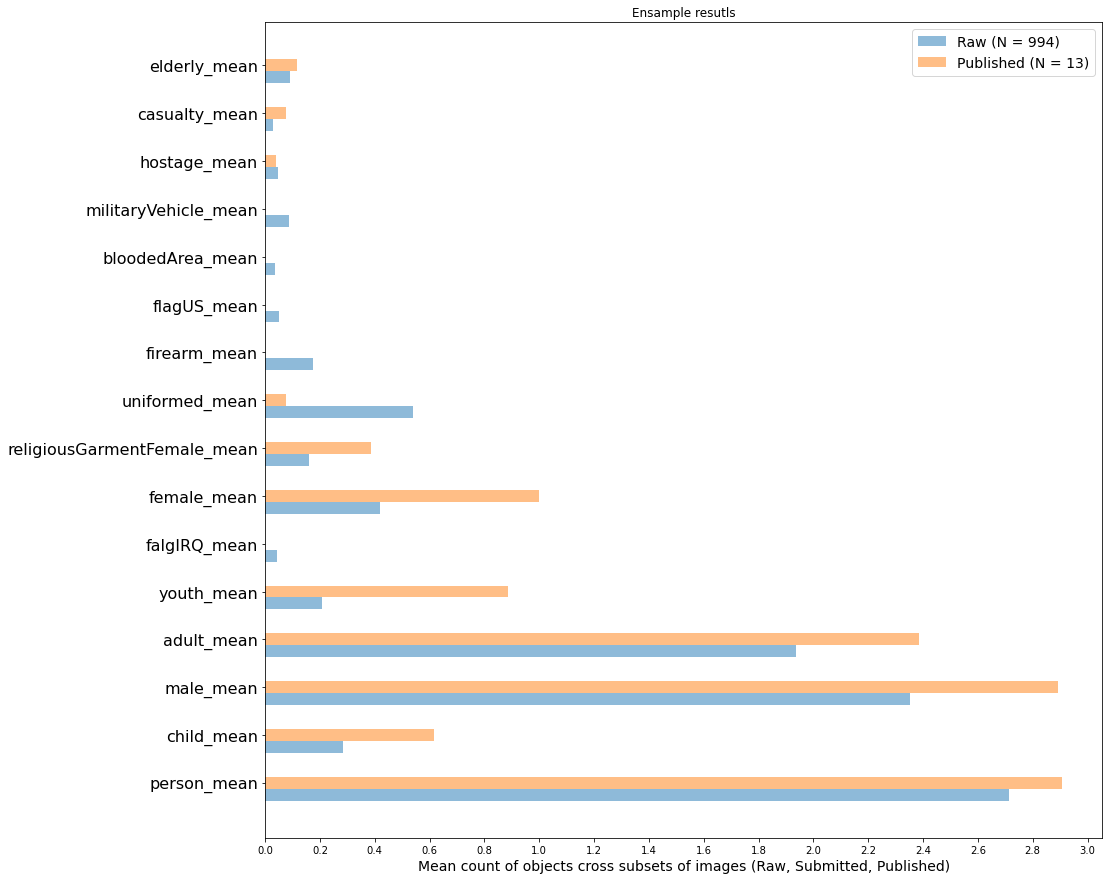

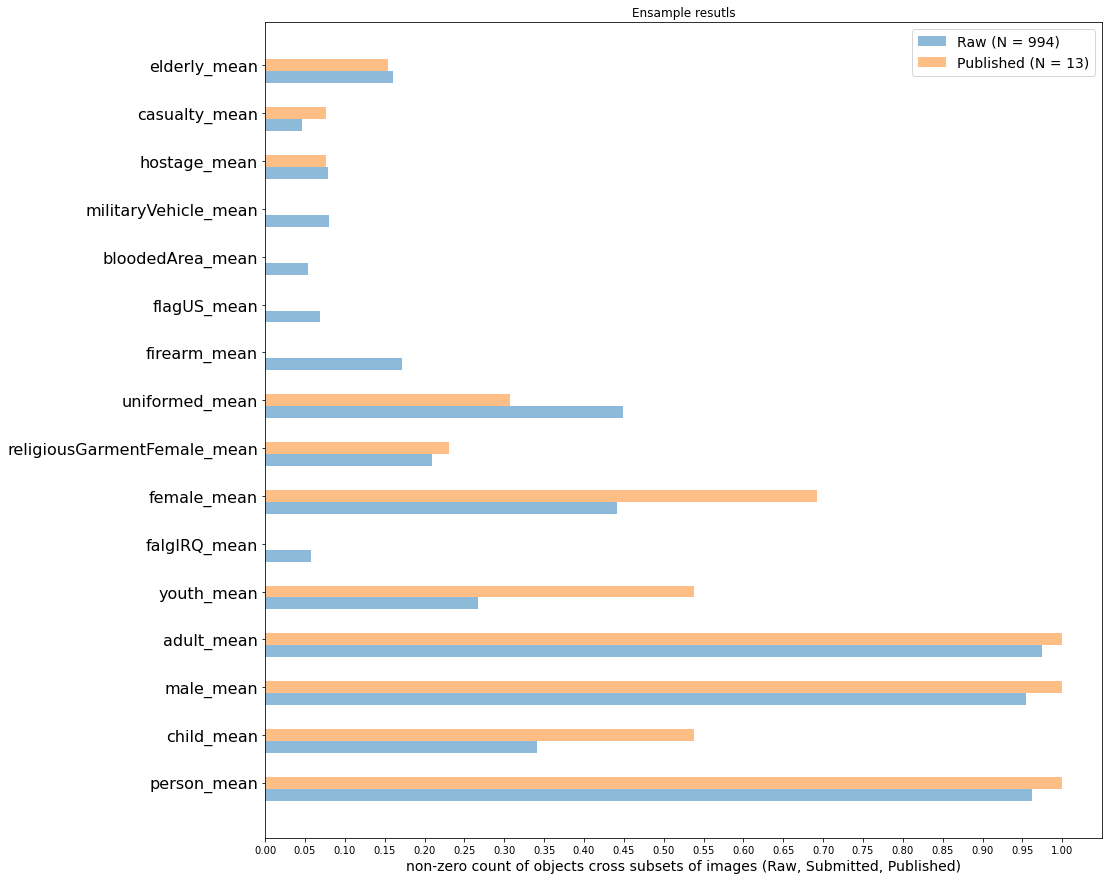

In [ ]:
feature_dist_plots(new_df, 'mean')
feature_dist_plots(new_df, 'dummy')

# DO FULL:

In [ ]:
def print_best_ts():

    list_ts = list(set([i['df_JSD'] for i in best_ts]))
    list_ts = sorted([float(i.split('t')[1])/100 for i in list_ts])
    print(list_ts)
    print(len(list_ts))

print_best_ts()


[0.1, 0.11, 0.17, 0.18, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.3, 0.31, 0.46, 0.48, 0.62, 0.75]
16


In [ ]:
# just to test as I am still missing df_t11 for full set
# also it does not matter since the corr for this feature (prayerInformal) is to low to use..
#best_ts[14]['df_JSD'] = 't10'

# NOTE
I generate these df using the script output_to_df

In [ ]:
df_dict_full = get_df_dict(True)
#best_ts_full = find_best_ts(df_dict_full)
new_df_full = get_new_df(df_dict_full, best_ts) #need to use the best_ts from annotation of course. And needs to be sure tha right fulls exist.

loading: OD_DF_FULL_t10.pkl
loading: OD_DF_FULL_t11.pkl
loading: OD_DF_FULL_t15.pkl
loading: OD_DF_FULL_t17.pkl
loading: OD_DF_FULL_t18.pkl
loading: OD_DF_FULL_t20.pkl
loading: OD_DF_FULL_t21.pkl
loading: OD_DF_FULL_t22.pkl
loading: OD_DF_FULL_t23.pkl
loading: OD_DF_FULL_t24.pkl
loading: OD_DF_FULL_t25.pkl
loading: OD_DF_FULL_t26.pkl
loading: OD_DF_FULL_t30.pkl
loading: OD_DF_FULL_t31.pkl
loading: OD_DF_FULL_t35.pkl
loading: OD_DF_FULL_t40.pkl
loading: OD_DF_FULL_t45.pkl
loading: OD_DF_FULL_t46.pkl
loading: OD_DF_FULL_t48.pkl
loading: OD_DF_FULL_t50.pkl
loading: OD_DF_FULL_t62.pkl
loading: OD_DF_FULL_t75.pkl


In [ ]:
df_dict_full['df_t21']

,img_id,adult_fasterR50,firearm_fasterR50,falgIRQ_fasterR50,person_fasterR50,uniformed_fasterR50,flagUS_fasterR50,militaryVehicle_fasterR50,male_fasterR50,adult_fasterR101,...,custom7,custom8,custom9,custom10,custom11,custom12,custom15,custom16,custom19,custom20
0,JS116733,0,0,0,4,0,0,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JS135838,0,1,0,3,3,0,2,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,JS103079,0,0,0,4,1,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,JS11401,1,0,0,8,0,0,0,7,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,JS46373,0,0,1,3,2,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152430,JS66284,0,1,0,6,4,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152431,JS20288,1,0,0,4,0,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152432,JS83118,1,0,0,7,0,0,0,4,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152433,JS100974,0,0,0,0,0,0,2,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


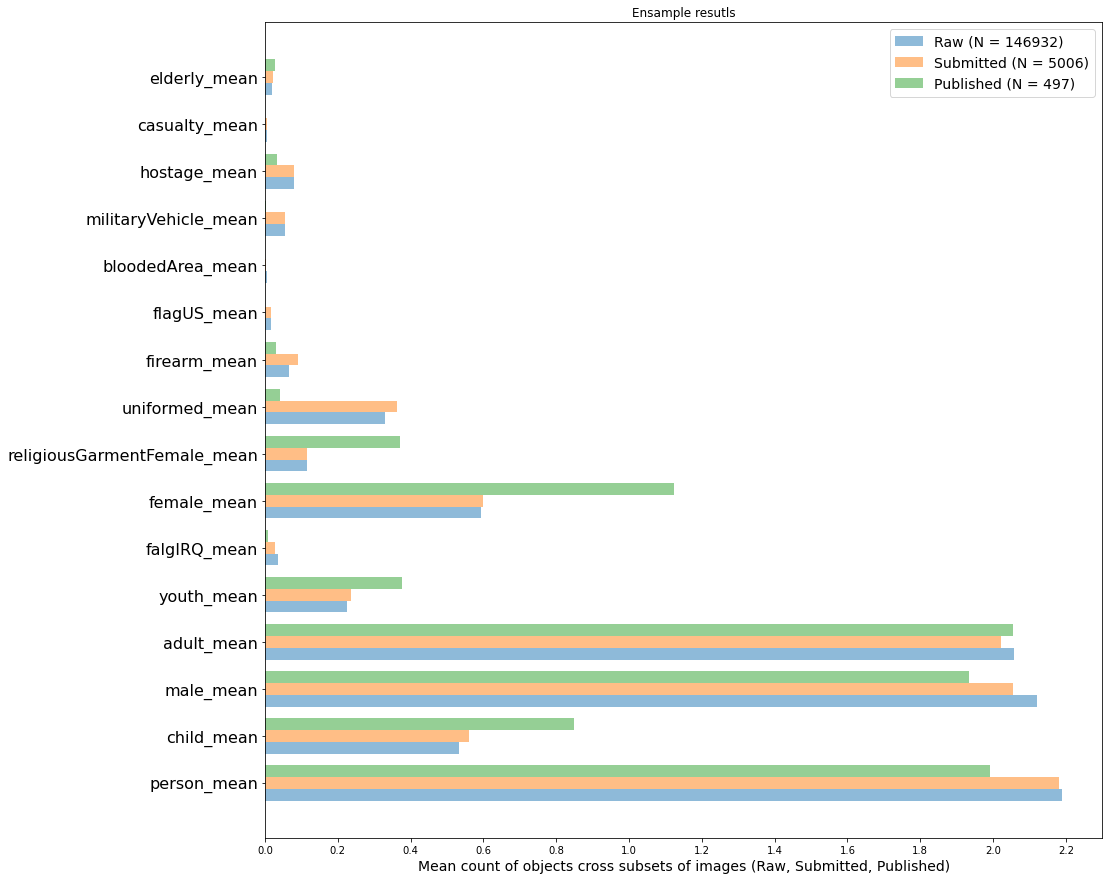

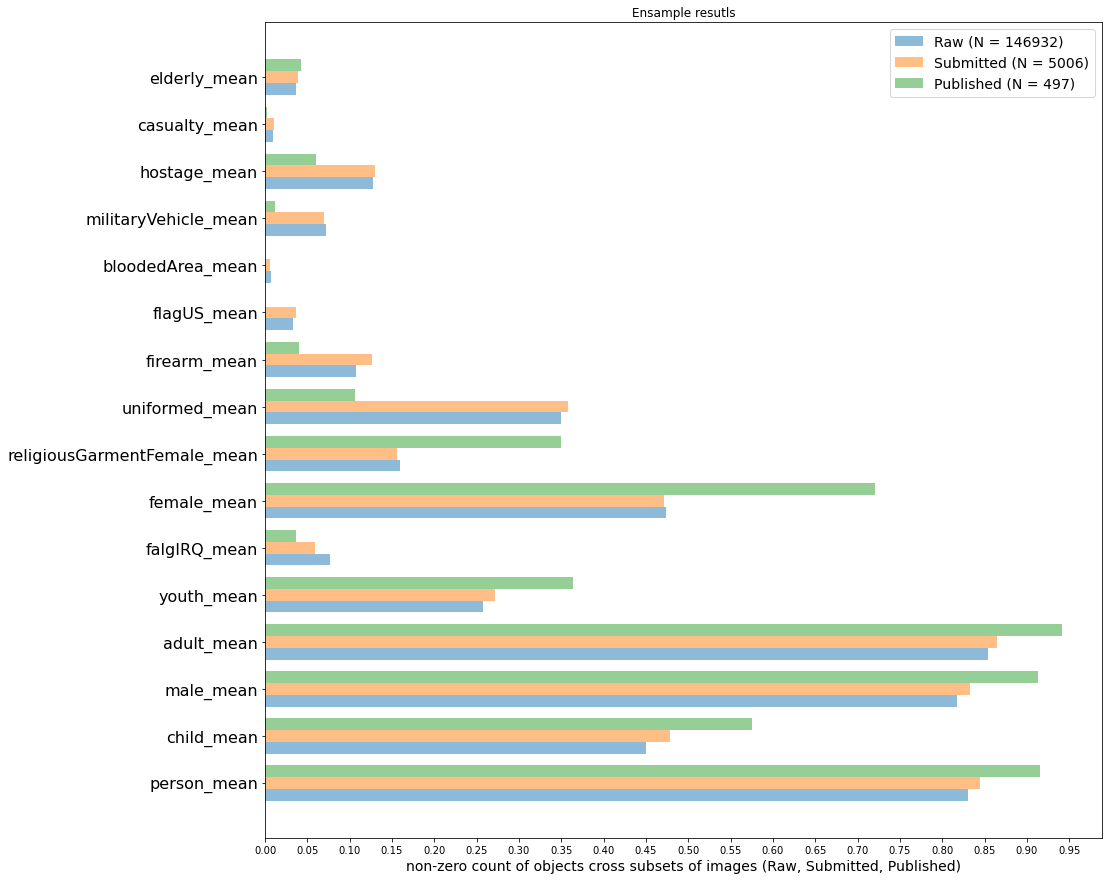

In [ ]:
feature_dist_plots(new_df_full, 'mean')
feature_dist_plots(new_df_full, 'dummy')

In [ ]:
new_df_full.to_csv('df_od_full_slim.csv') # that should no just be there....


with open('df_od_full_slim.pkl', 'wb') as file:
    pickle.dump(new_df_full, file)

In [ ]:
new_df_full

,person_mean,child_mean,male_mean,adult_mean,youth_mean,falgIRQ_mean,female_mean,religiousGarmentFemale_mean,uniformed_mean,firearm_mean,flagUS_mean,bloodedArea_mean,militaryVehicle_mean,hostage_mean,casualty_mean,elderly_mean,custom2,img_id
0,3.0,0.0,3.4,2.8,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Raw,JS116733
1,3.0,0.0,1.4,1.2,0.0,0.0,0.0,0.0,2.6,0.0,0.0,0.0,0.2,0.5,0.0,0.0,Raw,JS135838
2,1.6,0.0,1.6,2.4,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Raw,JS103079
3,5.6,1.5,7.0,6.4,0.5,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Raw,JS11401
4,2.8,0.0,1.4,1.8,0.0,0.8,0.0,0.0,2.4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,Raw,JS46373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152430,3.0,0.0,2.8,2.6,0.0,0.0,0.0,0.0,3.2,0.6,0.0,0.0,0.0,0.0,0.0,0.0,Raw,JS66284
152431,3.0,0.5,3.6,3.4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Raw,JS20288
152432,5.8,0.0,4.8,4.8,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.5,0.0,0.0,Raw,JS83118
152433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,0.0,0.0,0.0,Raw,JS100974


# OLD

In [74]:
# and just make likk 100 df and go. Manual grid search ftw.
df_dict['df_t30']['person_mean']

0       6.0
1       4.2
2       1.0
3       5.4
4       2.4
       ... 
1002    2.0
1003    5.0
1004    1.2
1005    2.6
1006    1.2
Name: person_mean, Length: 1007, dtype: float64

In [69]:
new_df_dict

{'person': 0,
 'child': 0,
 'male': 0,
 'adult': 0,
 'youth': 0,
 'falgIRQ': 0,
 'female': 0,
 'religiousGarmentFemale': 0,
 'uniformed': 0,
 'firearm': 0,
 'flagUS': 0,
 'infant': 0,
 'bloodedArea': 0,
 'militaryVehicle': 0,
 'prayerInformal': 0,
 'hostage': 0,
 'casualty': 0,
 'elderly': 0,
 'prayerSalah': 0}

In [ ]:
for df_name in df_dict.keys():

    print(df_name)

    df = df_dict[df_name]

    for feature in df.columns:
        if 'mean' in feature: # no meta features have this.
            feature_mean = feature
            feature_annotated = f'{feature.split("_")[0]}_annotated'

            corr = np.corrcoef(df[feature_mean], df[feature_annotated])[0,1]

            if corr > 0.3:
                print(f'{feature_mean.split("_")[0]}: {corr:.3}')
    print('\n')

In [60]:
t=0.1
df_name = f'df_t{int(t*100)}'
df = df_dict[df_name]

corr_dict = {}

feature = 'female'
feature_mean = f'{feature}_mean'
feature_annotated = f'{feature}_annotated'

models = ['fasterR50', 
          'fasterR101', 
          'fasterX101', 
          'retinaR50',  
          'retinaR101']

corr_mean = np.corrcoef(df[feature_mean], df[feature_annotated])[0,1]
#print(f'{corr_mean}\n')

w = 0
ws = 0

for model in models:
    feature_model = f'{feature}_{model}'
    corr = np.corrcoef(df[feature_model], df[feature_annotated])[0,1]
    ws += corr
    w += df[feature_model] * corr
    
    #corr_dict[model] = corr

    #print(corr)

alt_ens = w/ws

print(np.corrcoef(alt_ens, df[feature_annotated])[0,1])
print(np.corrcoef(df[feature_mean], df[feature_annotated])[0,1])

0.331486307698419

0.33577700076463357

In [ ]:
#alt_ens = ((97.2 * 0.84) + (100.0 * 0.87) + (95.8 * 0.75)) / (0.84 + 0.87 + 0.75)



In [52]:
corr_dict

{'fasterR50': 0.24329754643941937,
 'fasterR101': 0.19176430468195543,
 'fasterX101': 0.130304264819579,
 'retinaR50': 0.2604585069966178,
 'retinaR101': 0.3238203938827703}

In [40]:
df[f'{feature}_{model}']

0       19
1       13
2        2
3       10
4        7
        ..
1002     7
1003    11
1004     4
1005    11
1006     5
Name: person_retinaR101, Length: 1007, dtype: int64

In [38]:
for i in df.columns:
    print(i)

img_id
male_fasterR50
uniformed_fasterR50
militaryVehicle_fasterR50
religiousGarmentFemale_fasterR50
flagUS_fasterR50
falgIRQ_fasterR50
person_fasterR50
female_fasterR50
firearm_fasterR50
adult_fasterR50
male_fasterR101
uniformed_fasterR101
militaryVehicle_fasterR101
religiousGarmentFemale_fasterR101
flagUS_fasterR101
falgIRQ_fasterR101
person_fasterR101
female_fasterR101
firearm_fasterR101
adult_fasterR101
casualty_fasterR101
male_fasterX101
uniformed_fasterX101
militaryVehicle_fasterX101
flagUS_fasterX101
falgIRQ_fasterX101
person_fasterX101
female_fasterX101
firearm_fasterX101
adult_fasterX101
casualty_fasterX101
infant_retinaR50
hostage_retinaR50
bloodedArea_retinaR50
youth_retinaR50
casualty_retinaR50
male_retinaR50
religiousGarmentFemale_retinaR50
elderly_retinaR50
militaryVehicle_retinaR50
prayerInformal_retinaR50
person_retinaR50
firearm_retinaR50
adult_retinaR50
uniformed_retinaR50
flagUS_retinaR50
falgIRQ_retinaR50
female_retinaR50
prayerSalah_retinaR50
child_retinaR50
infant

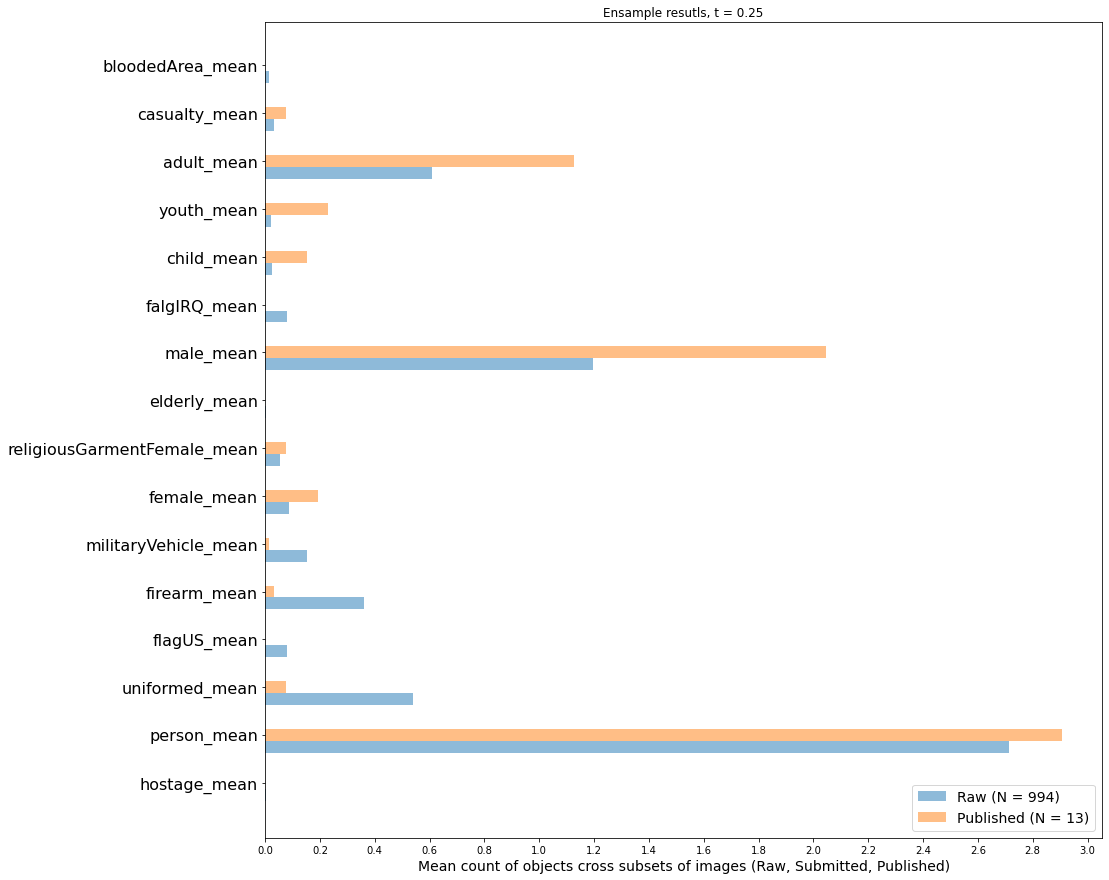

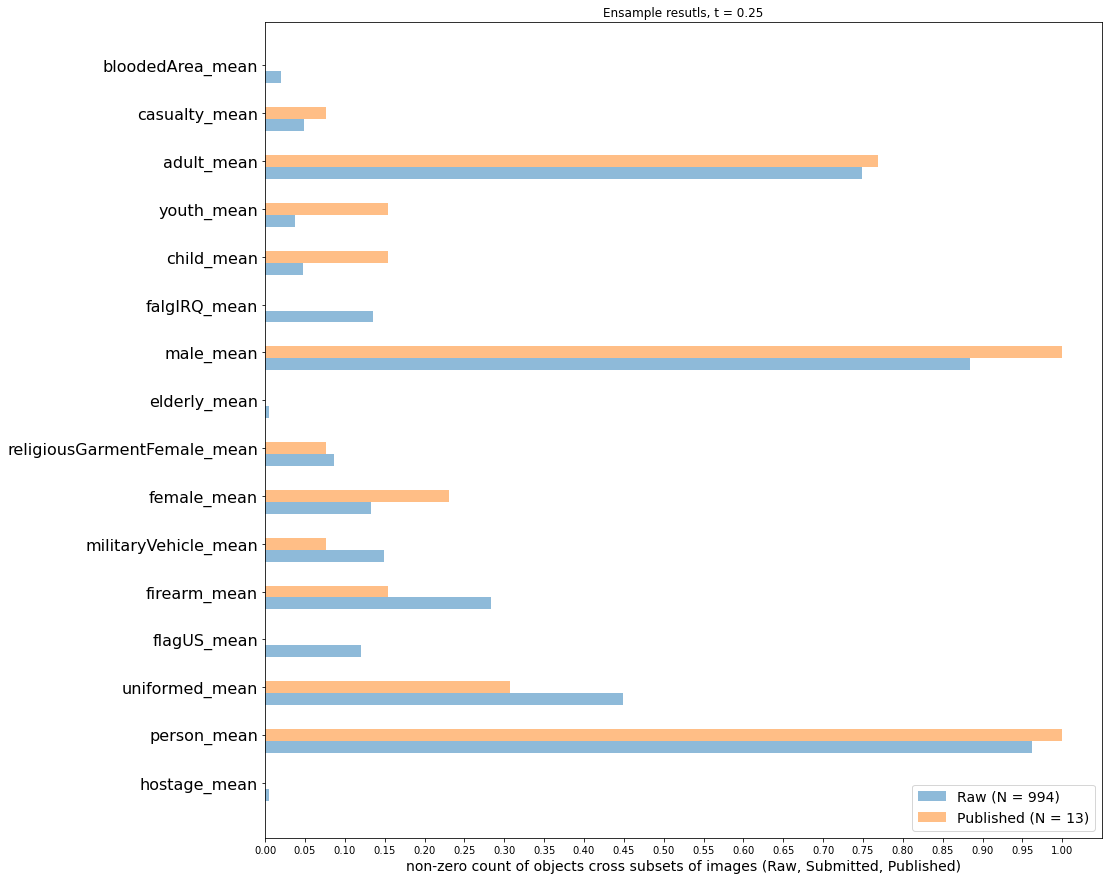

In [54]:
t=0.30
df_name = f'df_t{int(t*100)}'
df = df_dict[df_name]

feature_dist_plots(df, 'mean')
feature_dist_plots(df, 'dummy')

In [37]:
get_KLD()

df_t10: 0.09674440453336947
df_t15: 0.08523327228151331
df_t20: 0.07343610368503366
df_t25: 0.062034693487138255
df_t30: 0.05800693016645027


In [16]:
stats.entropy?

Signature: stats.entropy(pk, qk=None, base=None, axis=0)
Docstring:
Calculate the entropy of a distribution for given probability values.

If only probabilities `pk` are given, the entropy is calculated as
``S = -sum(pk * log(pk), axis=axis)``.

If `qk` is not None, then compute the Kullback-Leibler divergence
``S = sum(pk * log(pk / qk), axis=axis)``.

This routine will normalize `pk` and `qk` if they don't sum to 1.

Parameters
----------
pk : sequence
    Defines the (discrete) distribution. ``pk[i]`` is the (possibly
    unnormalized) probability of event ``i``.
qk : sequence, optional
    Sequence against which the relative entropy is computed. Should be in
    the same format as `pk`.
base : float, optional
    The logarithmic base to use, defaults to ``e`` (natural logarithm).
axis: int, optional
    The axis along which the entropy is calculated. Default is 0.

Returns
-------
S : float
    The calculated entropy.

Examples
--------

>>> from scipy.stats import entropy

Bernoul

In [10]:
t = 0.25

df_name = f'df_t{int(t*100)}'
df = df_dict[df_name]

In [11]:
df

,img_id,adult_fasterR50,male_fasterR50,falgIRQ_fasterR50,person_fasterR50,militaryVehicle_fasterR50,firearm_fasterR50,uniformed_fasterR50,flagUS_fasterR50,male_fasterR101,...,headline,credit,source,copyright notice,caption/abstract,writer/editor,custom1,custom2,custom3,custom4
0,JS9617,0,3,0,6,0,2,1,0,2,...,NaN,Johan Spanner/WorldPictureNews,Johan Spanner/WorldPictureNews,Johan Spanner/WorldPictureNews,NaN,Johan Spanner/WorldPictureNews,Spanner,Raw,2004,DSC_3166.JPG
1,JS12373,0,2,0,4,0,0,0,1,1,...,Jul i Camp Eden,Johan Spanner/WorldPictureNews,Johan Spanner/WorldPictureNews,Johan Spanner/WorldPictureNews,"24 Dec. 2003\rAl-Qurnah/Basra, Irak\rJul hos d...",Johan Spanner/WorldPictureNews,Spanner,Raw,2004,DSC_1222.JPG
2,JS37420,0,0,1,1,0,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Spanner,Raw,2005,DSC_2924.JPG
3,JS20086,0,4,0,7,0,0,0,0,4,...,New Iraqi Army Training,Polaris Images,NaN,Johan Spanner/Polaris,Second batallion of the new Iraqi Army is bein...,NaN,Spanner,Raw,2005,DSC_5390.JPG
4,JS43977,0,0,0,2,0,1,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Spanner,Raw,2005,DSC_5575.JPG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002,JS43601,0,0,0,2,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Spanner,Raw,2005,DSC_4361.JPG
1003,JS20361,0,4,0,5,0,0,0,0,3,...,NaN,NaN,NaN,NaN,NaN,NaN,Spanner,Raw,2005,DSC_5538.JPG
1004,JS5195,0,0,0,2,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,Spanner,Raw,2003,DSC_1593.TIF
1005,JS14721,0,2,0,3,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,Spanner,Raw,2005,DSC_0358.NEF


In [9]:
for df_name in df_dict.keys():

    print(df_name)

    df = df_dict[df_name]

    for feature in df.columns:
        if 'mean' in feature: # no meta features have this.
            feature_mean = feature
            feature_annotated = f'{feature.split("_")[0]}_annotated'

            corr = np.corrcoef(df[feature_mean], df[feature_annotated])[0,1]

            if corr > 0.3:
                print(f'{feature_mean.split("_")[0]}: {corr:.3}')
    print('\n')

df_t10
falgIRQ: 0.729
youth: 0.382
male: 0.803
flagUS: 0.745
militaryVehicle: 0.805
person: 0.827
firearm: 0.809
adult: 0.713
uniformed: 0.774
female: 0.336
child: 0.338


df_t15
child: 0.322
firearm: 0.86
person: 0.852
falgIRQ: 0.778
youth: 0.43
militaryVehicle: 0.822
flagUS: 0.766
male: 0.818
adult: 0.722
female: 0.333
bloodedArea: 0.309
religiousGarmentFemale: 0.33
uniformed: 0.794


df_t20
uniformed: 0.821
casualty: 0.309
firearm: 0.885
falgIRQ: 0.801
adult: 0.736
bloodedArea: 0.319
militaryVehicle: 0.848
youth: 0.406
person: 0.868
female: 0.366
flagUS: 0.759
male: 0.83
religiousGarmentFemale: 0.341


df_t25
militaryVehicle: 0.872
adult: 0.677
youth: 0.338
flagUS: 0.77
male: 0.821
religiousGarmentFemale: 0.341
person: 0.882
female: 0.34
firearm: 0.902
uniformed: 0.839
falgIRQ: 0.829
bloodedArea: 0.363
casualty: 0.355


df_t30
person: 0.882
uniformed: 0.826
flagUS: 0.808
firearm: 0.898
militaryVehicle: 0.895
male: 0.755
falgIRQ: 0.854
adult: 0.484
casualty: 0.418
bloodedArea: 0.432


/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/simon/anaconda3/envs/new_torch_env/lib/python3.8/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [81]:
for df_name in df_dict.keys():

    print(df_name)

    df = df_dict[df_name]

    for feature in df.columns:
        # mean, median, retinaR50, fasterR50
        if 'retinaR101' in feature: # no meta features have this.
            feature_model = feature
            feature_annotated = f'{feature.split("_")[0]}_annotated'

            corr = np.corrcoef(df[feature_model], df[feature_annotated])[0,1]

            if corr < 0.3:
                print(f'{feature_model.split("_")[0]}: {corr:.3}')
    print('\n')

df_t10
infant: -0.00951
hostage: 0.178
bloodedArea: 0.13
casualty: 0.246
religiousGarmentFemale: 0.285
elderly: 0.0857
prayerInformal: -0.00315
prayerSalah: -0.0079


df_t15
casualty: 0.253
bloodedArea: 0.222
elderly: 0.0479
infant: -0.00447
prayerInformal: -0.00141
prayerSalah: -0.00352
hostage: 0.222


df_t20
hostage: 0.173
bloodedArea: 0.212
elderly: 0.0297
infant: -0.00316
child: 0.296
prayerSalah: -0.00117


df_t25
child: 0.154
youth: 0.225
hostage: -0.0158
bloodedArea: 0.134
elderly: -0.0249


df_t30
hostage: -0.00877
bloodedArea: 0.0858
female: 0.183
elderly: -0.0143
religiousGarmentFemale: 0.238
child: 0.128
youth: 0.121


df_t35
bloodedArea: 0.153
female: 0.148
religiousGarmentFemale: 0.176
elderly: -0.00638
child: 0.0286
adult: 0.118
youth: 0.0578
hostage: -0.00554


df_t40
religiousGarmentFemale: 0.103
adult: 0.0633
youth: 0.11
female: 0.0831
child: -0.0107


df_t45
male: 0.281
adult: 0.0325
female: 0.0248


df_t50
casualty: 0.145
male: 0.132
adult: 0.00287


df_t55
adult: 0

# WE ARE GOOD AT:
- firearms
- persons (adult and male as a function here of..)
- militaryVehicle
- uniformed
- flagUS
- falgIRQ

# We are less good at (but maybe it can be done..)
- child
- female
- religiousGarmentFemale
- casualty

# We are really bad at
- infant
- hostage
- blooded Area
- elderly
- prayer (Informal)
- prayer (Salah)


In [ ]:
# t = 0.3
# df_name = f'df_t{int(t*100)}'
# plot_corr(df_dict[df_name])

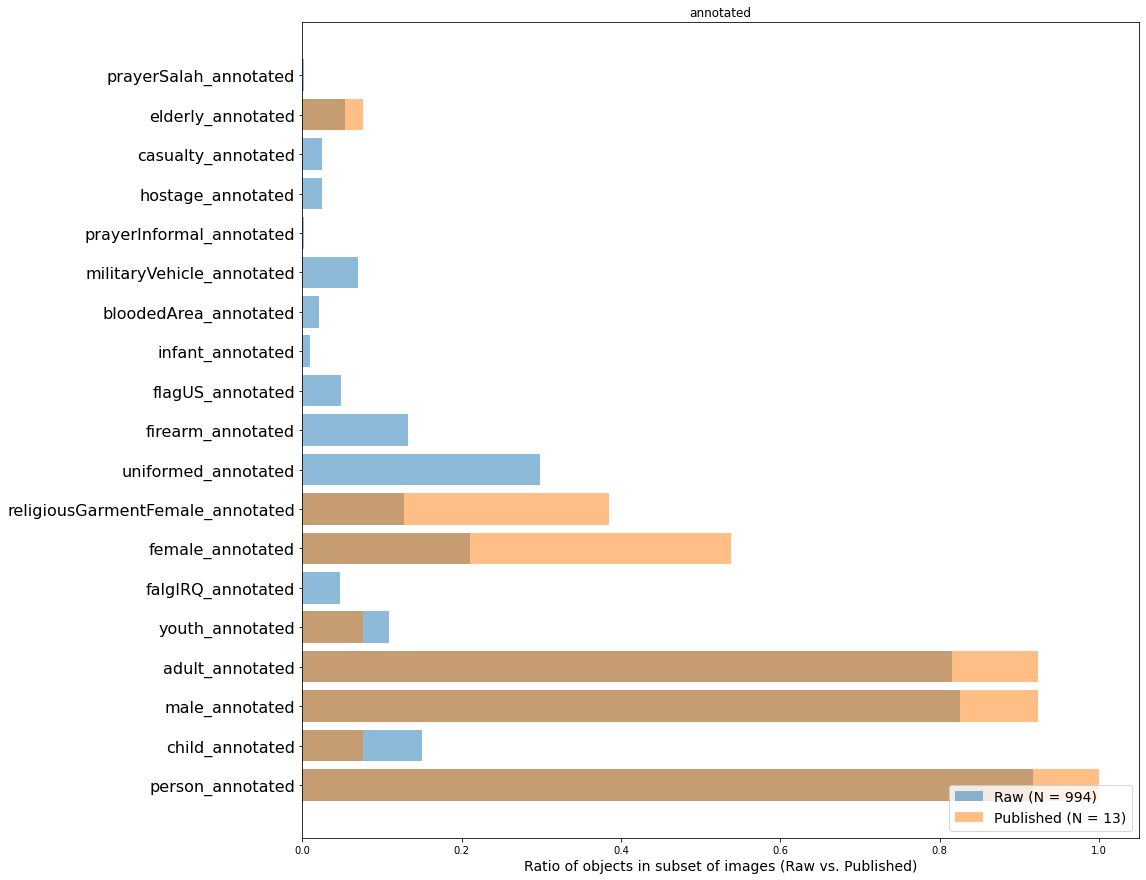

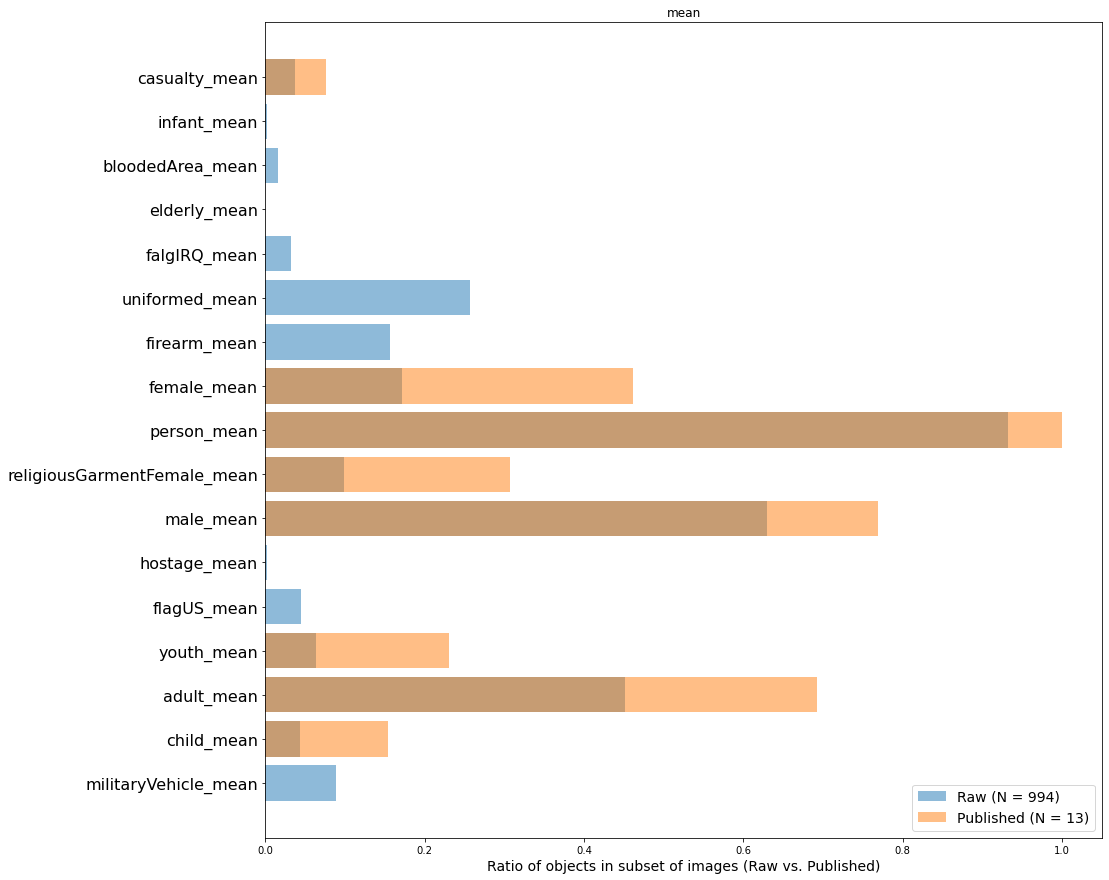

In [80]:
t = 0.25
t = 0.5

df_name = f'df_t{int(t*100)}'
df = df_dict[df_name]

# feature_version_list = ['annotated', 'mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50']
feature_version_list = ['annotated', 'mean']

for i in feature_version_list:
    feature_dist_plots(df, i)

# FULL

In [3]:
df_dict = {}
t_range = np.arange(0.1, 0.55, 0.05)

for t in t_range:
    df_name = f'df_t{int(t*100)}'
    df_dict[df_name] = open_df(True, t)
    print(f'Done w/ {df_name}')
    # debug...
    # print(df_dict[df_name]['firearm_mean'].mean())

loading: OD_DF_FULL_t10.pkl
Done w/ df_t10
loading: OD_DF_FULL_t15.pkl
Done w/ df_t15
loading: OD_DF_FULL_t20.pkl
Done w/ df_t20
loading: OD_DF_FULL_t25.pkl
Done w/ df_t25
loading: OD_DF_FULL_t30.pkl
Done w/ df_t30
loading: OD_DF_FULL_t35.pkl
Done w/ df_t35
loading: OD_DF_FULL_t40.pkl
Done w/ df_t40
loading: OD_DF_FULL_t45.pkl
Done w/ df_t45
loading: OD_DF_FULL_t50.pkl
Done w/ df_t50


In [4]:
for key in df_dict.keys():

    print(key)
    print(df_dict[key]['firearm_mean'].mean())

df_t10
1.1519795322596837
df_t15
0.6371332043163483
df_t20
0.4052402663429458
df_t25
0.2871361563945176
df_t30
0.21836454882413728
df_t35
0.17317545183196617
df_t40
0.14155410502839832
df_t45
0.11811460622561955
df_t50
0.09971332043166833


In [34]:
df_dict[key]['firearm_mean'].mean()

0.09971332043166833

In [5]:
df_dict['df_t10'].sample(10)

,img_id,flagUS_fasterR50,male_fasterR50,adult_fasterR50,militaryVehicle_fasterR50,falgIRQ_fasterR50,person_fasterR50,child_fasterR50,uniformed_fasterR50,religiousGarmentFemale_fasterR50,...,custom7,custom8,custom9,custom10,custom11,custom12,custom15,custom16,custom19,custom20
63533,JS51310,0,4,4,0,0,4,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23449,JS89506,0,2,3,0,0,3,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140949,JS35740,2,8,6,0,1,7,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41838,JS90413,0,2,3,0,0,5,0,3,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108850,JS99242,0,4,5,0,0,5,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
135825,JS123473,0,3,3,0,0,5,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81963,JS64201,0,3,1,0,0,5,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132520,JS60004,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106571,JS145128,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76157,JS56557,0,11,10,0,0,16,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#t = 0.1
t = 0.5

df_name = f'df_t{int(t*100)}'
df = df_dict[df_name]

In [41]:
df['firearm_mean'].mean() 

0.2871361563945176

In [40]:
(df['firearm_mean'] > 0).mean() #sum()/df.shape[0]

0.3112408567586184

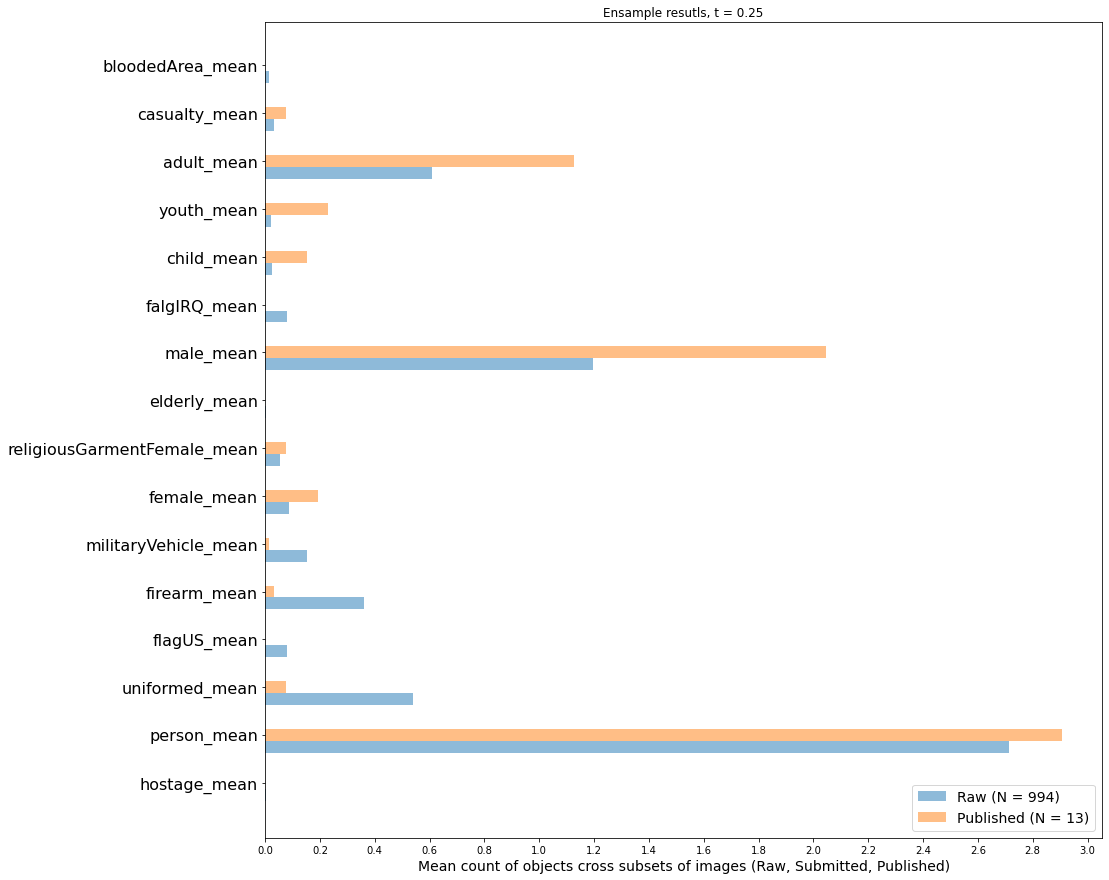

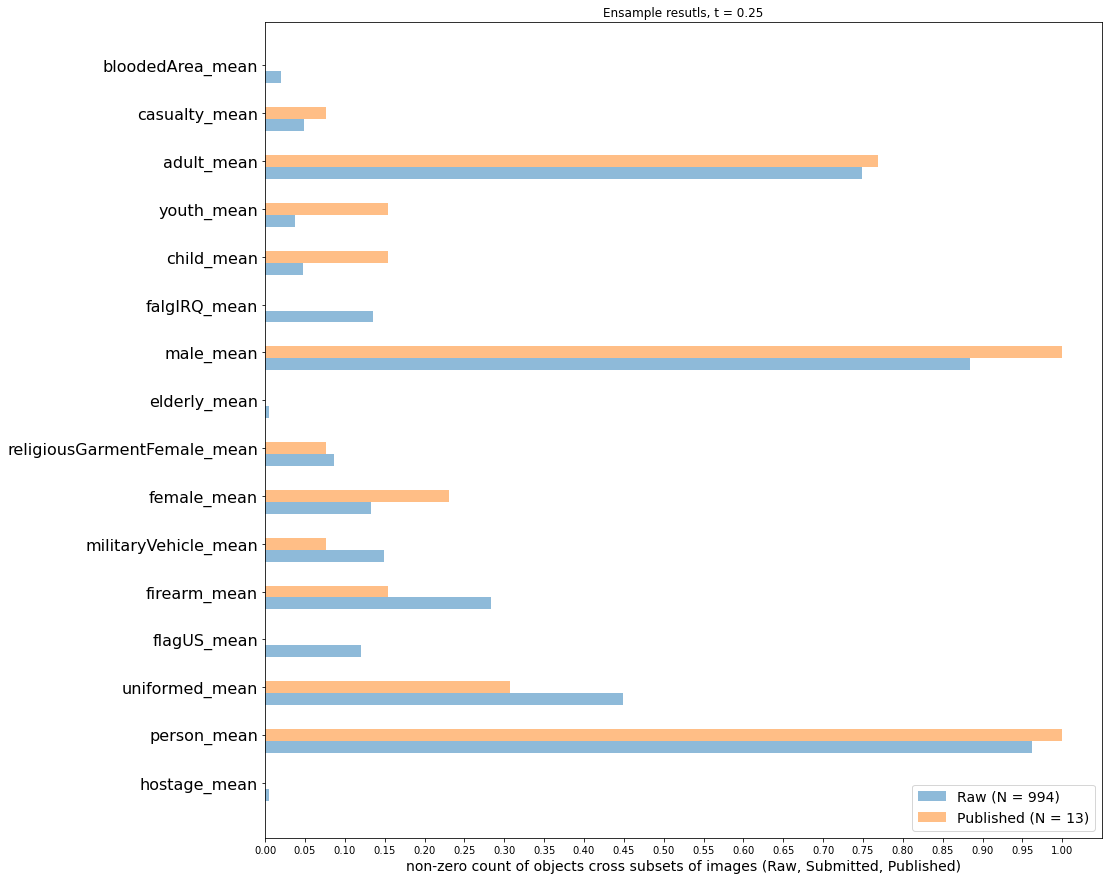

In [28]:
t=0.30
df_name = f'df_t{int(t*100)}'
df = df_dict[df_name]

feature_dist_plots(df, 'mean')
feature_dist_plots(df, 'dummy')

In [61]:
(df[df['custom2'] == 'Published']['person_mean'] > 0).mean()

0.9416498993963782

In [62]:
(df[df['custom2'] == 'Submitted']['person_mean'] > 0).mean()

0.8643627646823812

In [63]:
(df[df['custom2'] == 'Raw']['person_mean'] > 0).mean()

0.8508561783682248

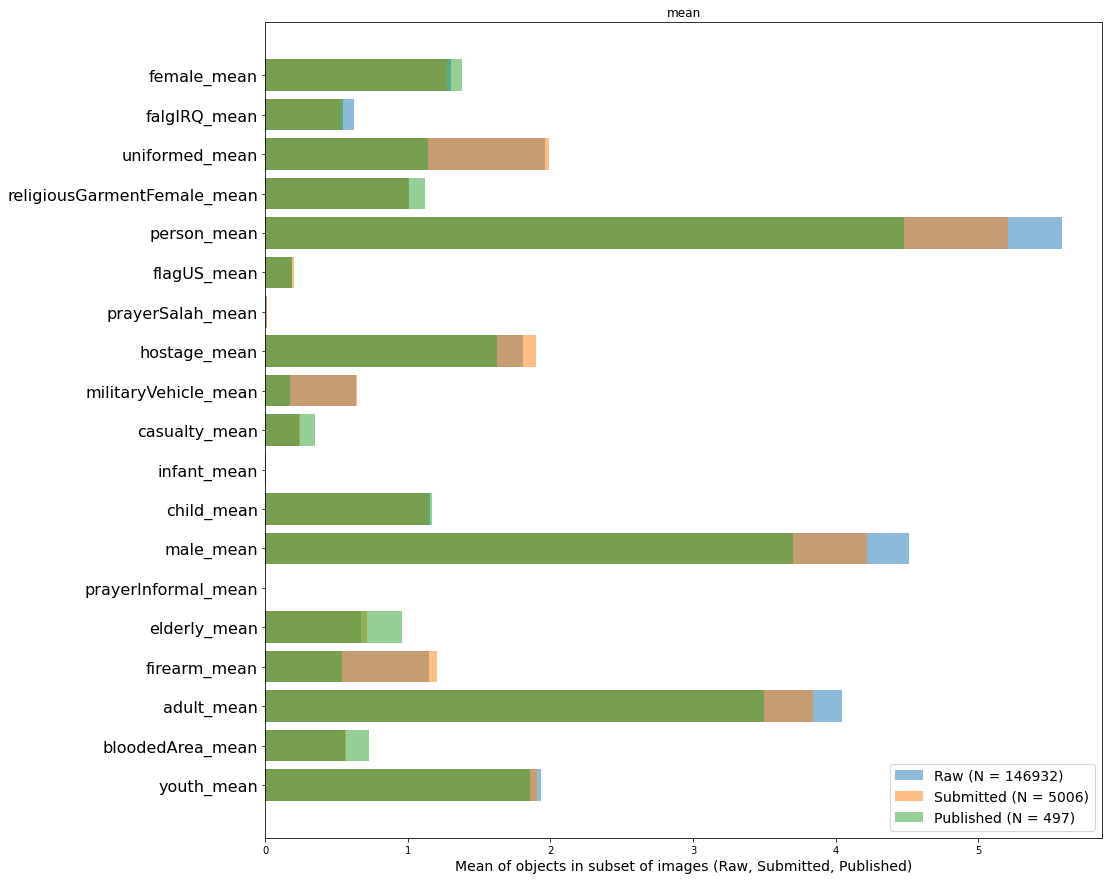

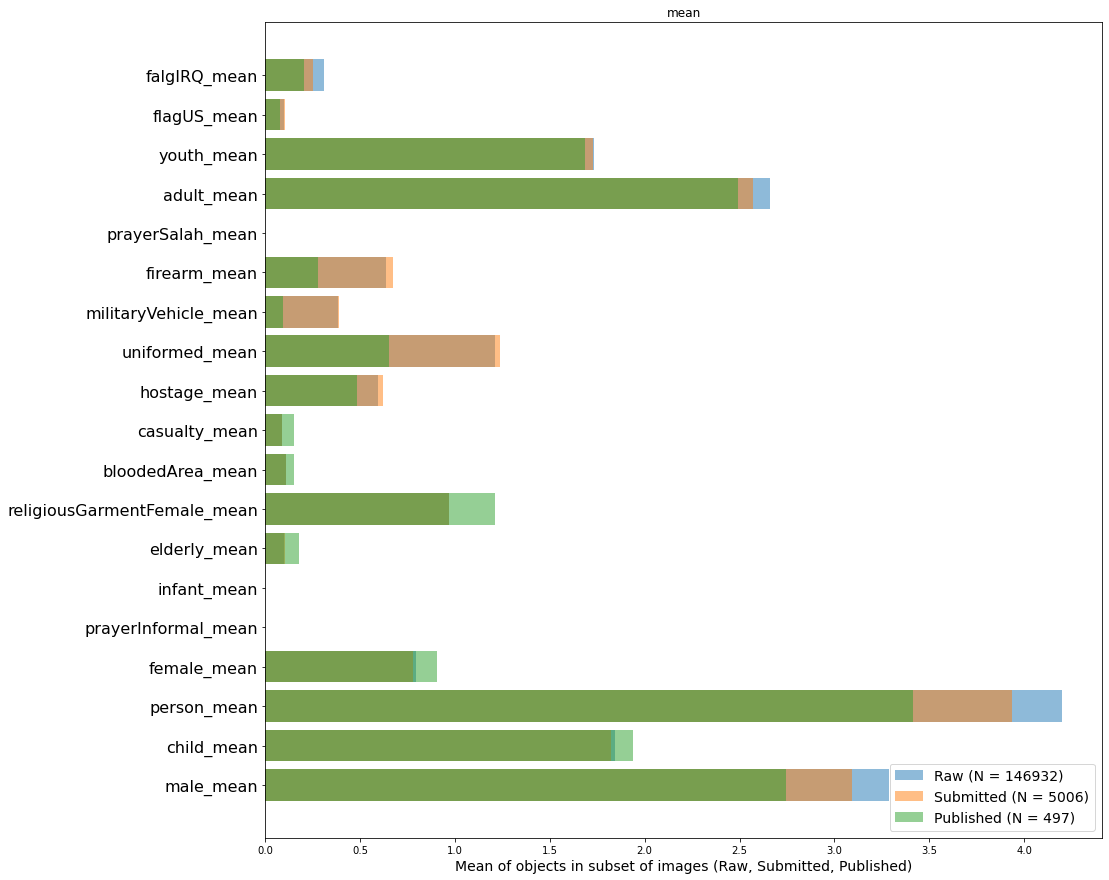

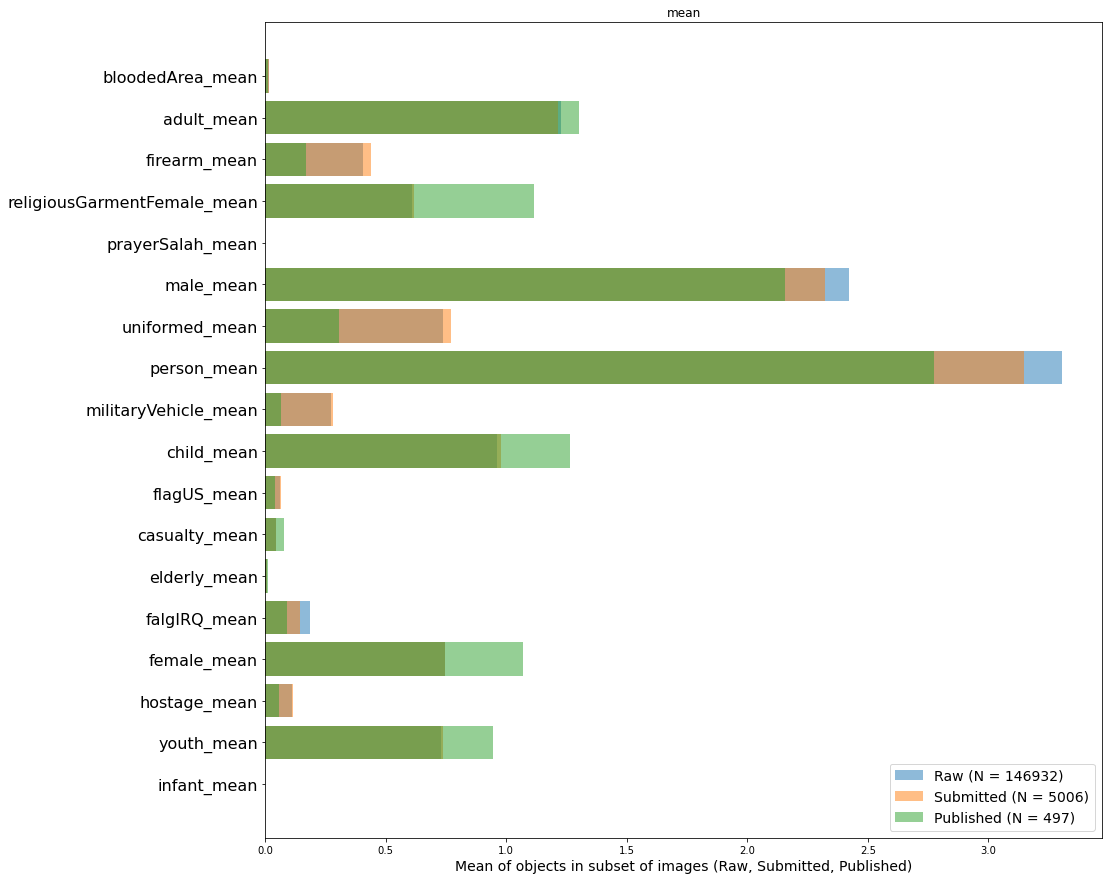

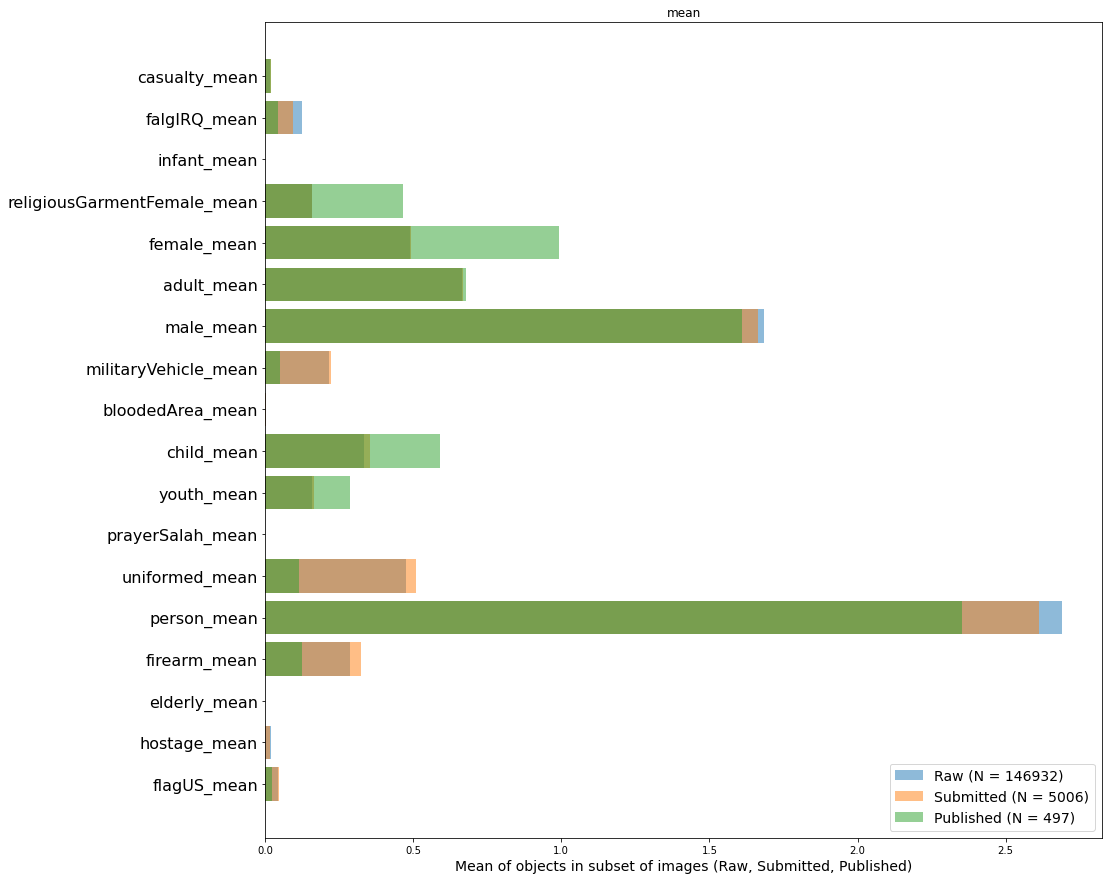

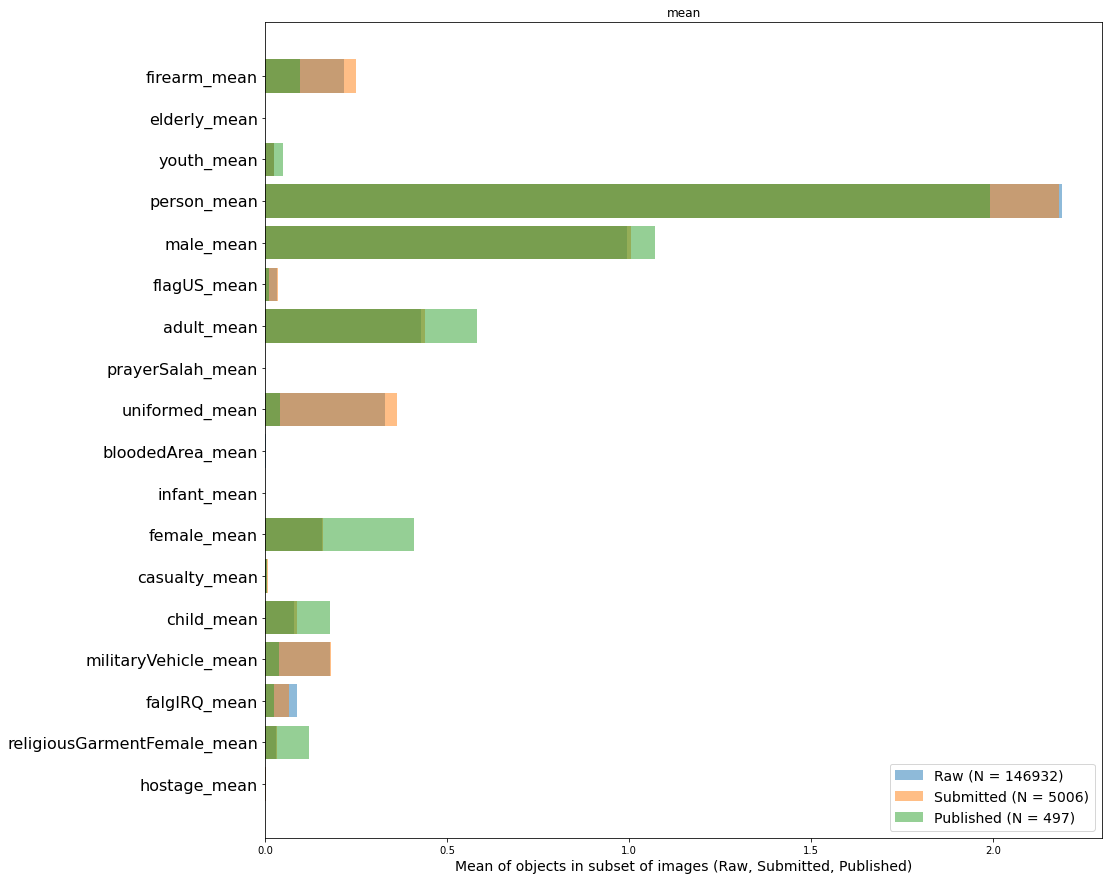

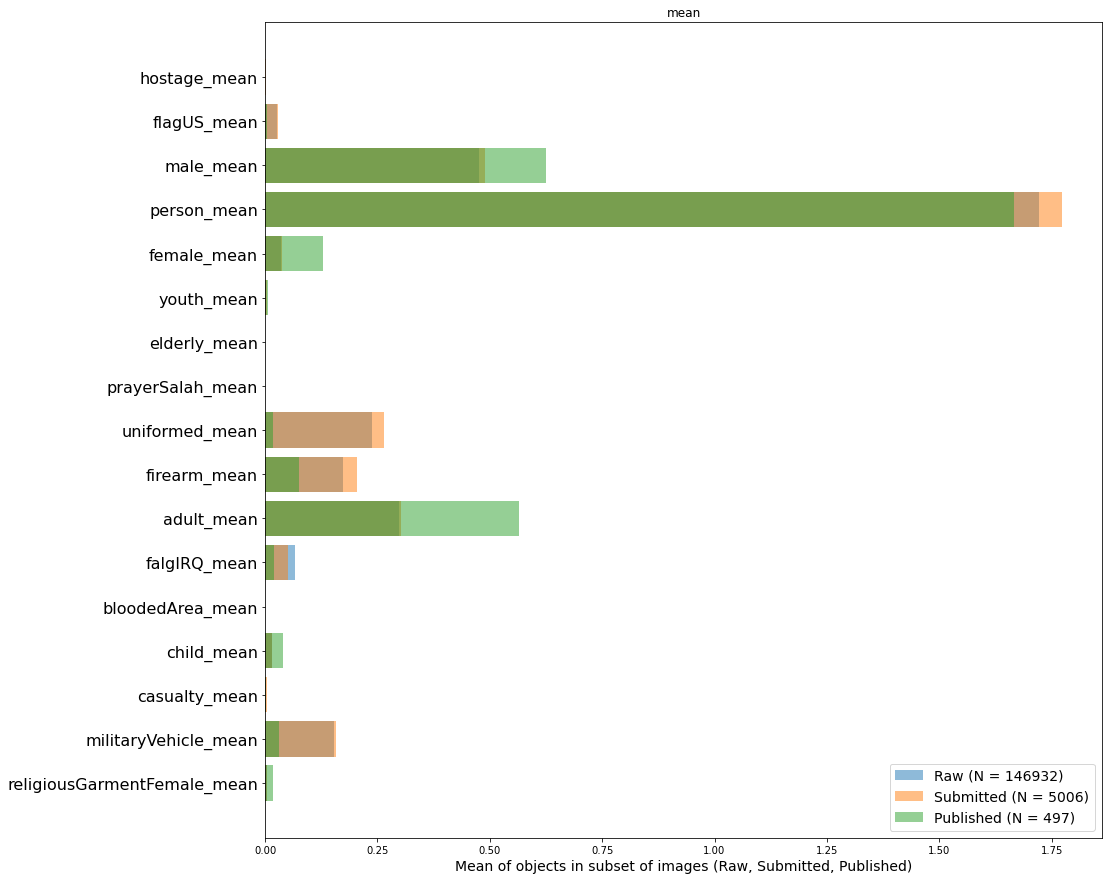

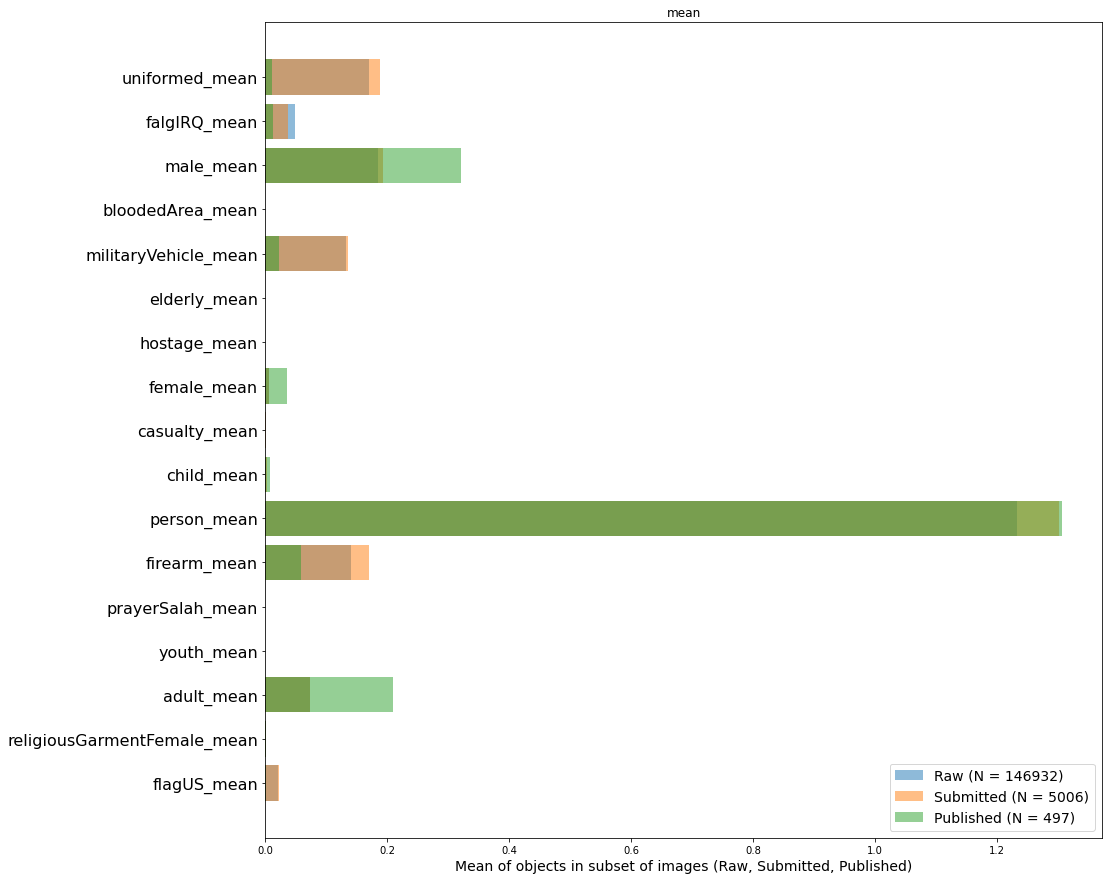

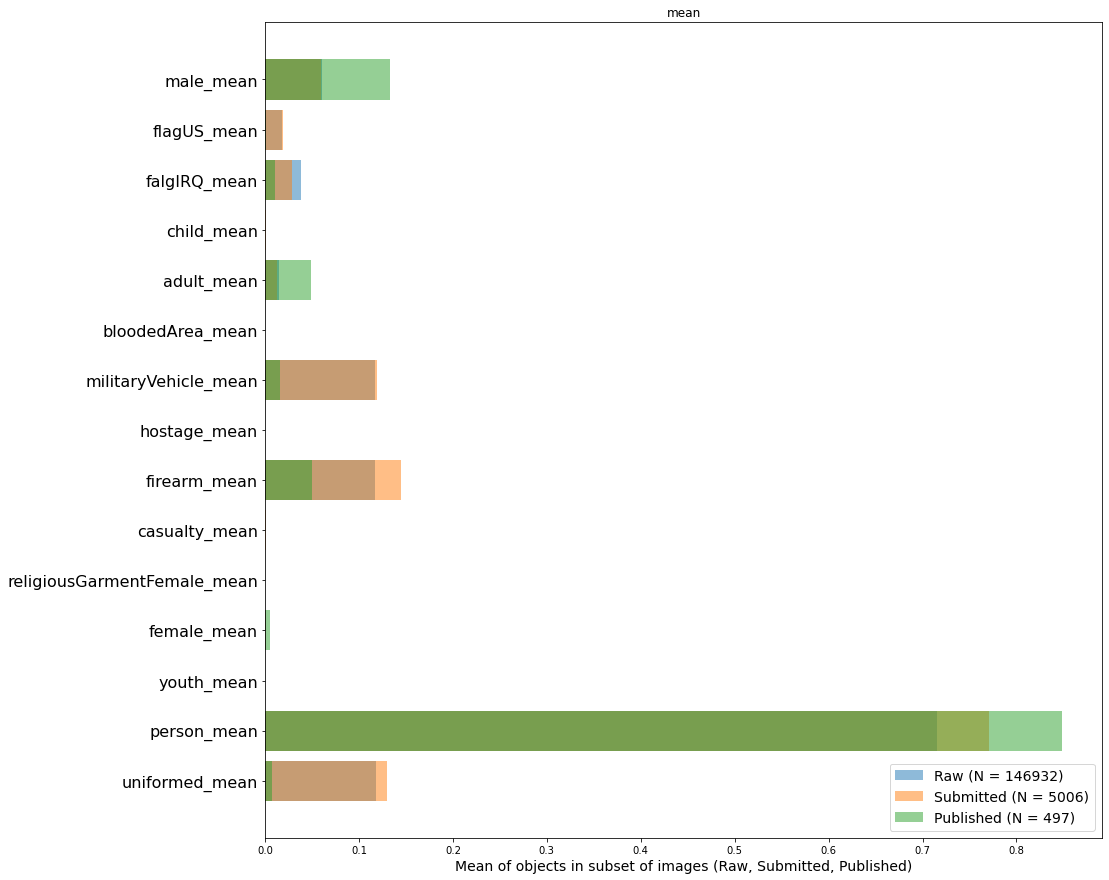

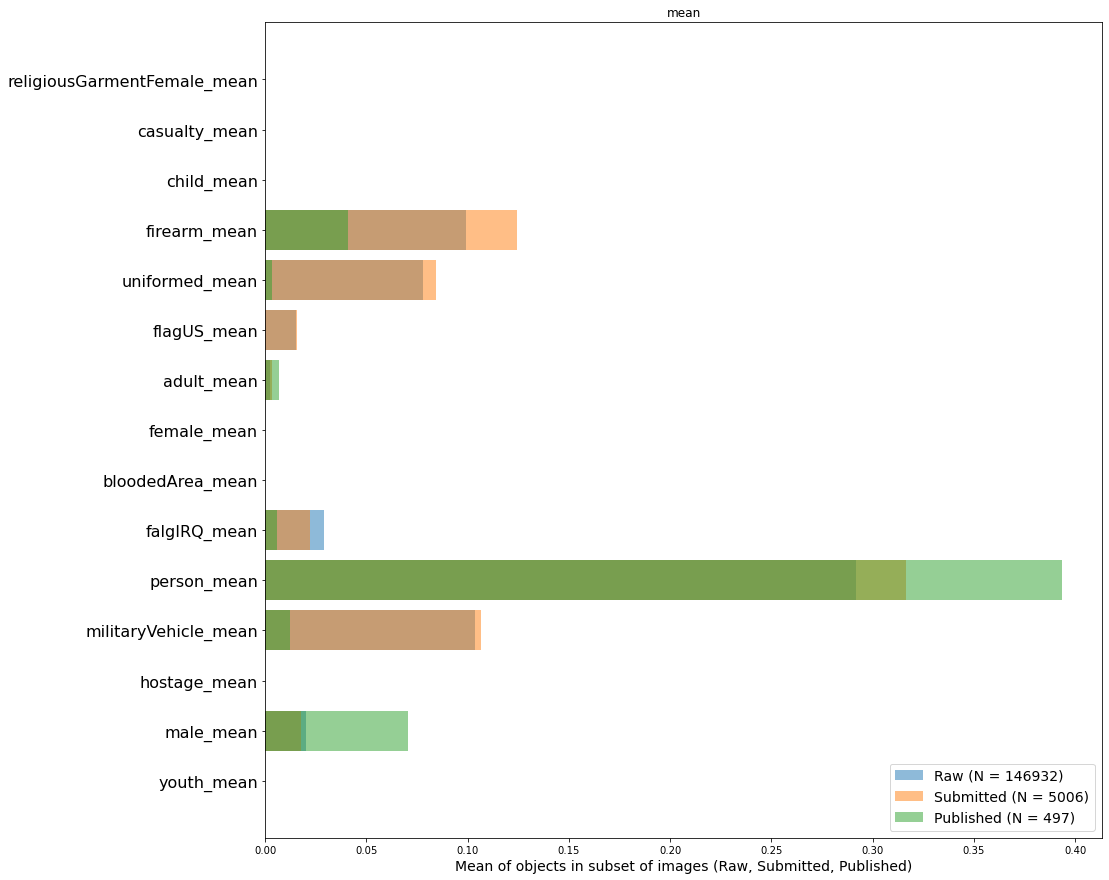

In [51]:
for t in np.arange(0.1, 0.55, 0.05):

    df_name = f'df_t{int(t*100)}'
    df = df_dict[df_name]

    feature_dist_plots(df, 'mean')

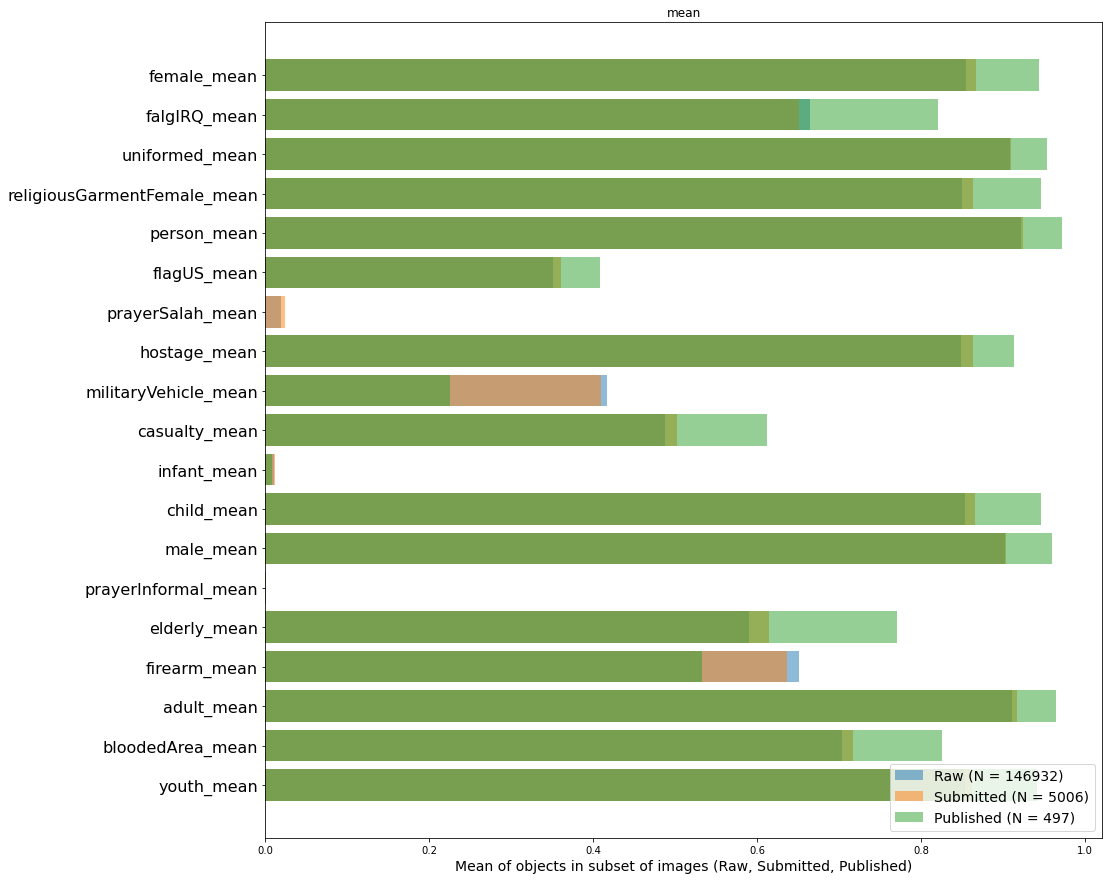

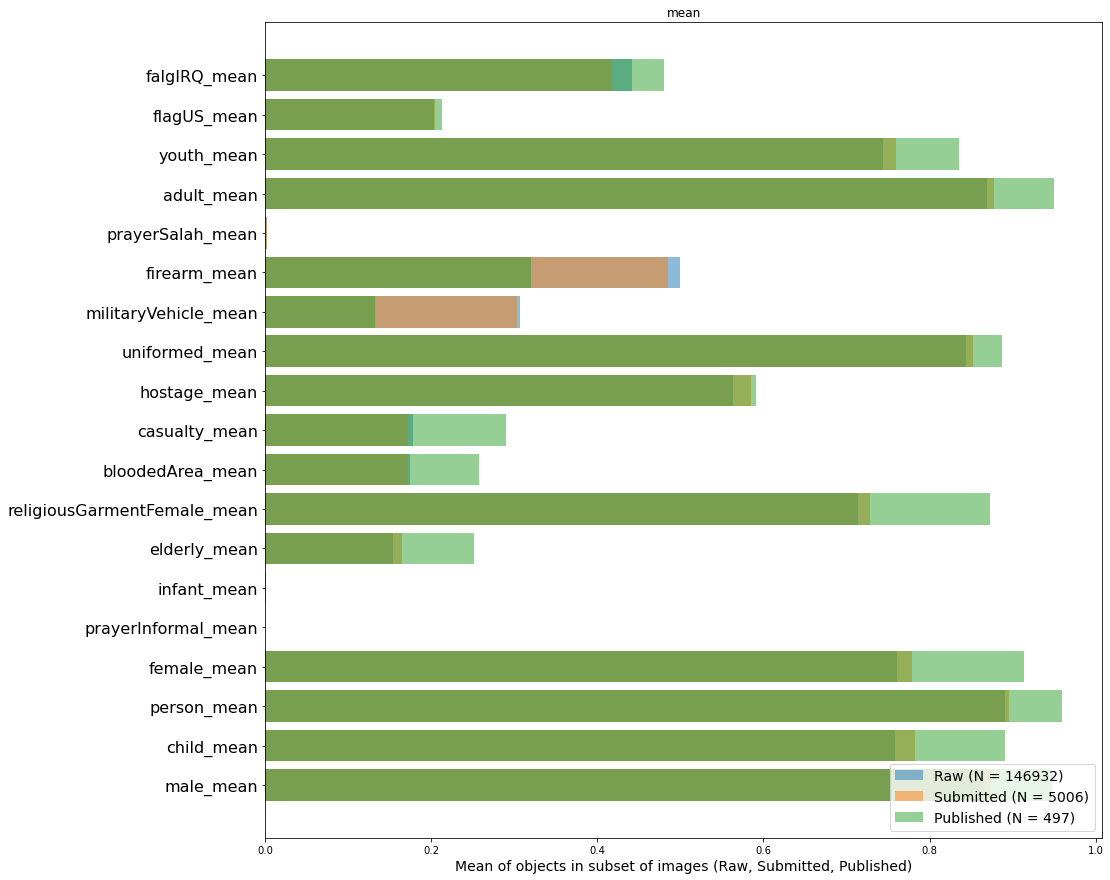

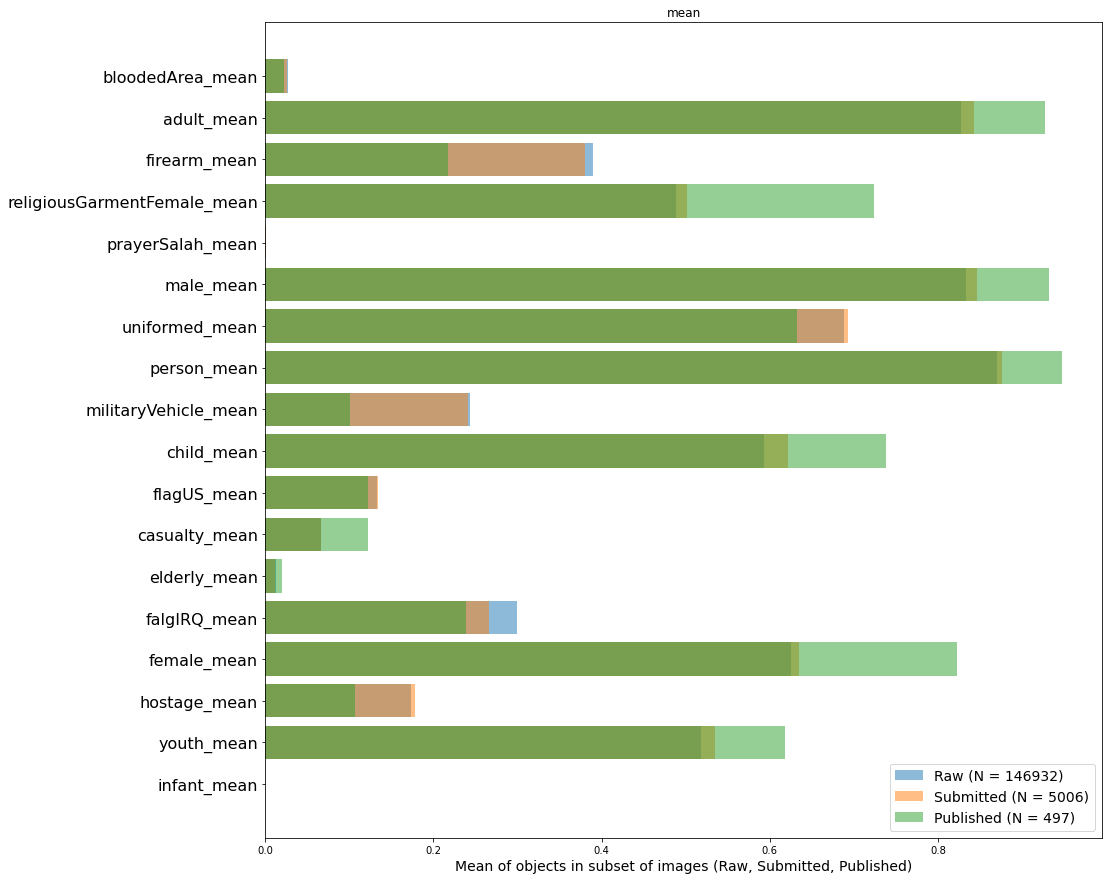

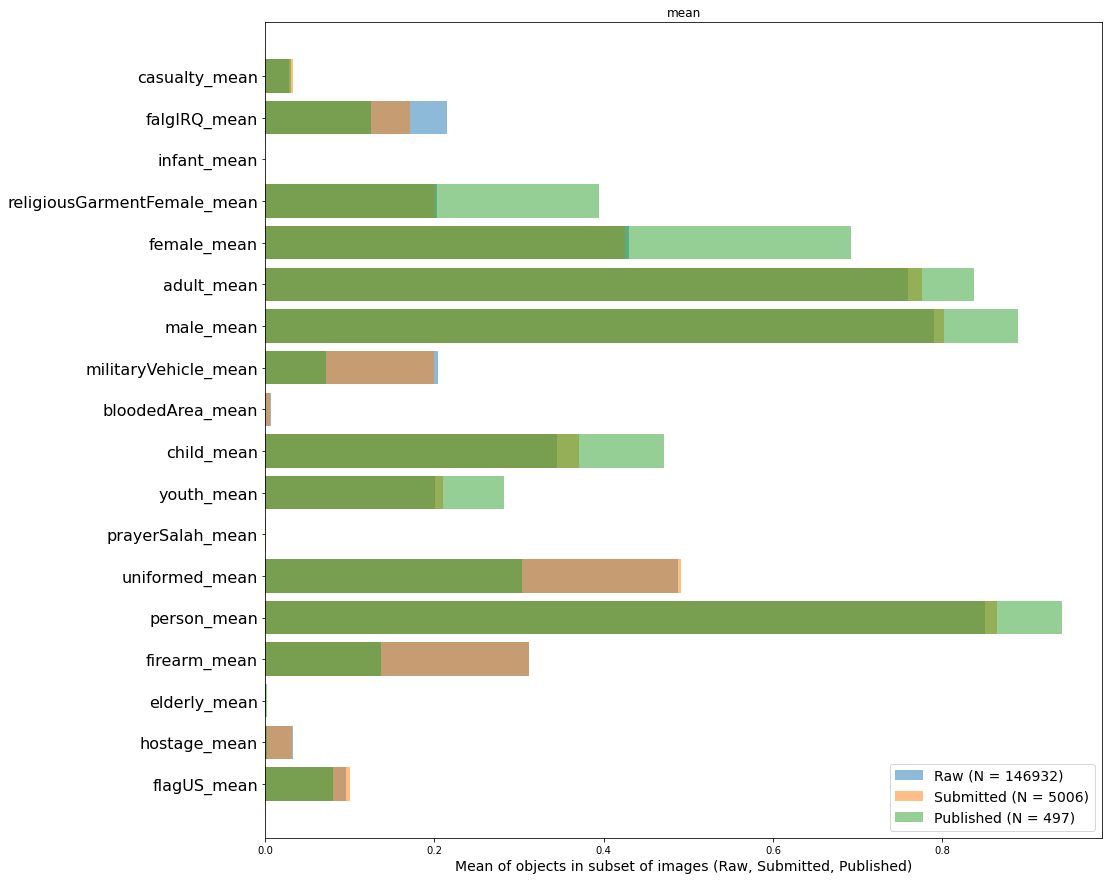

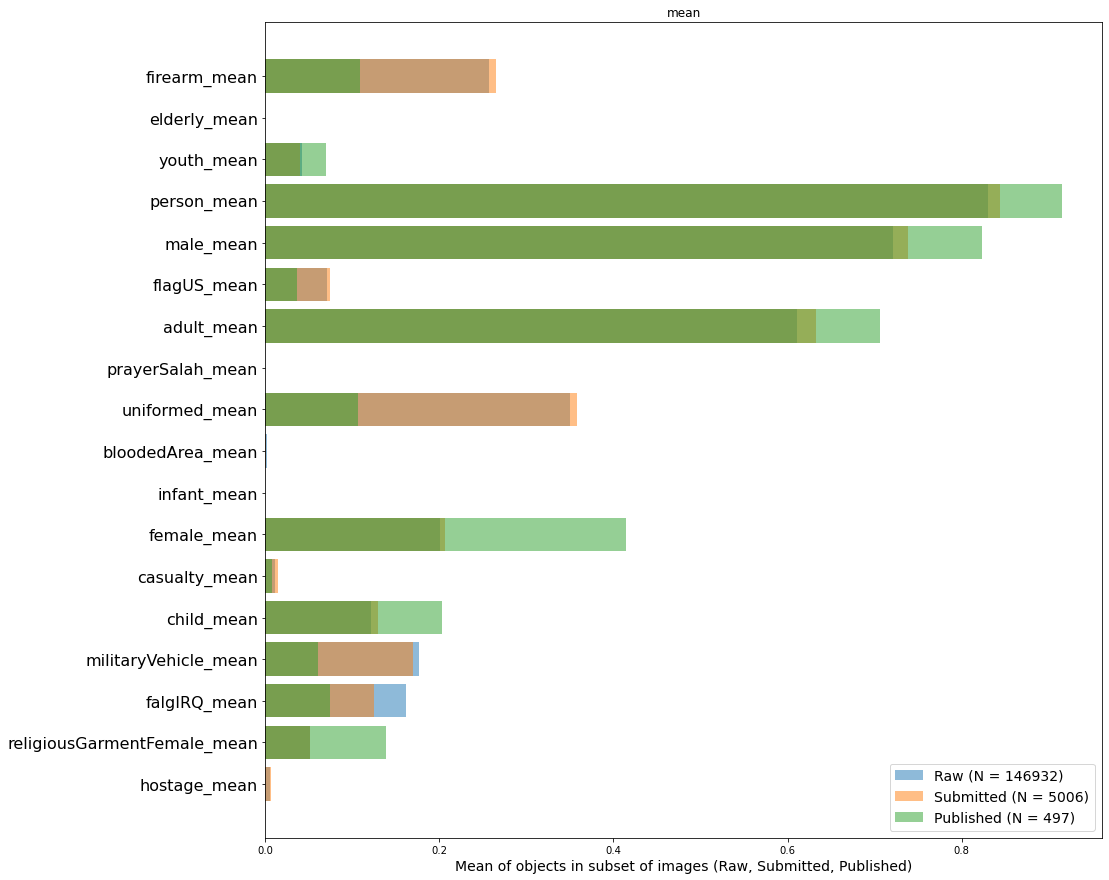

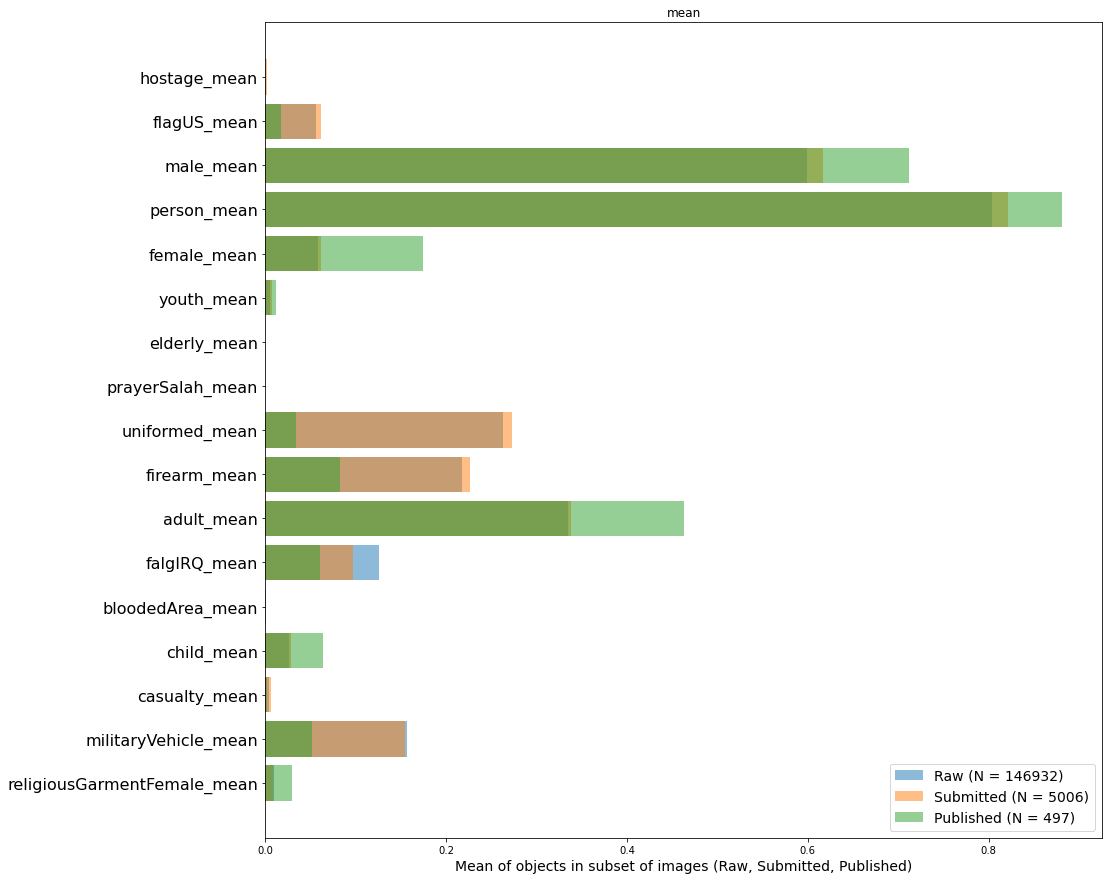

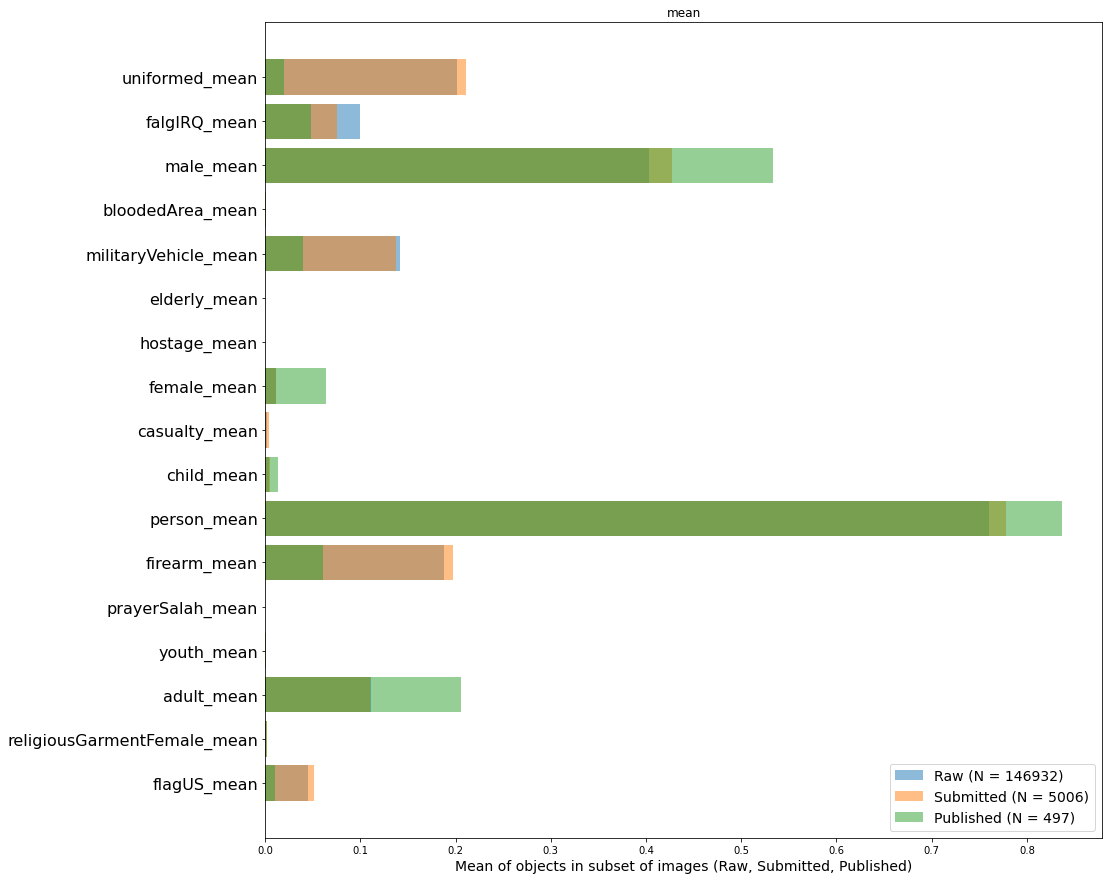

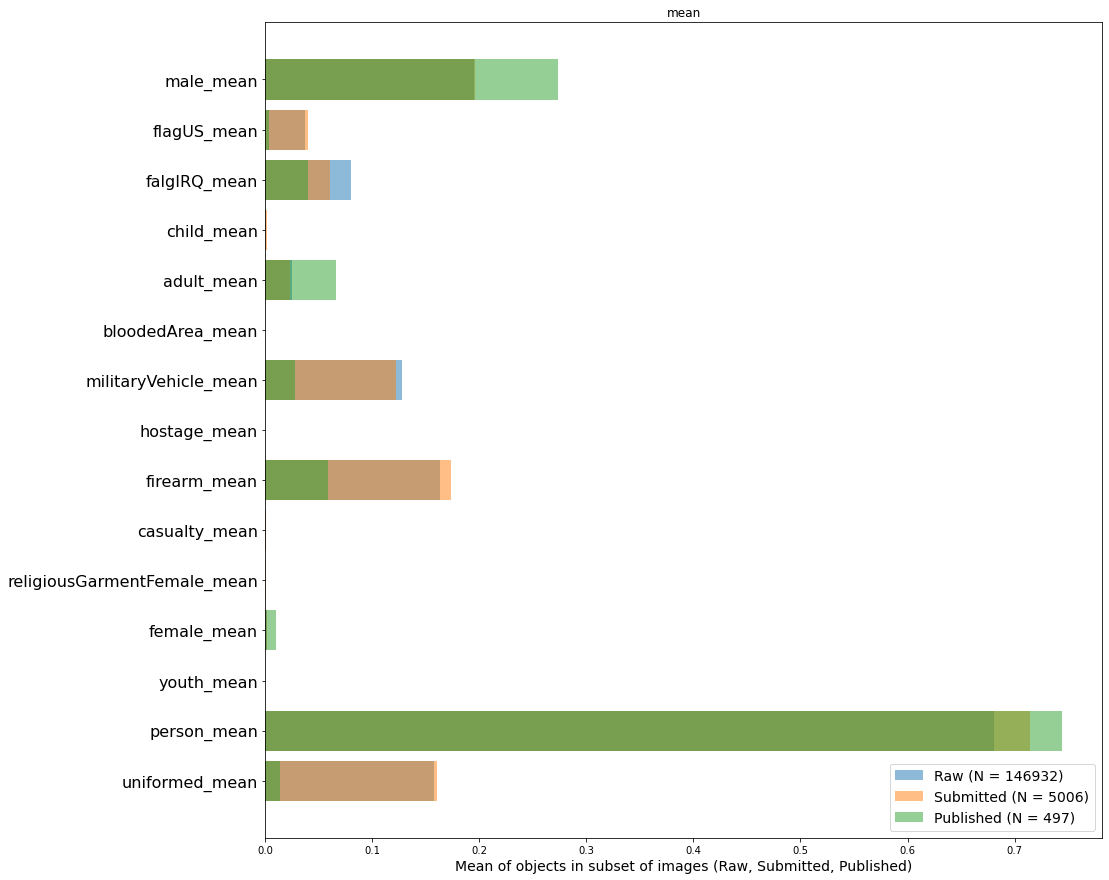

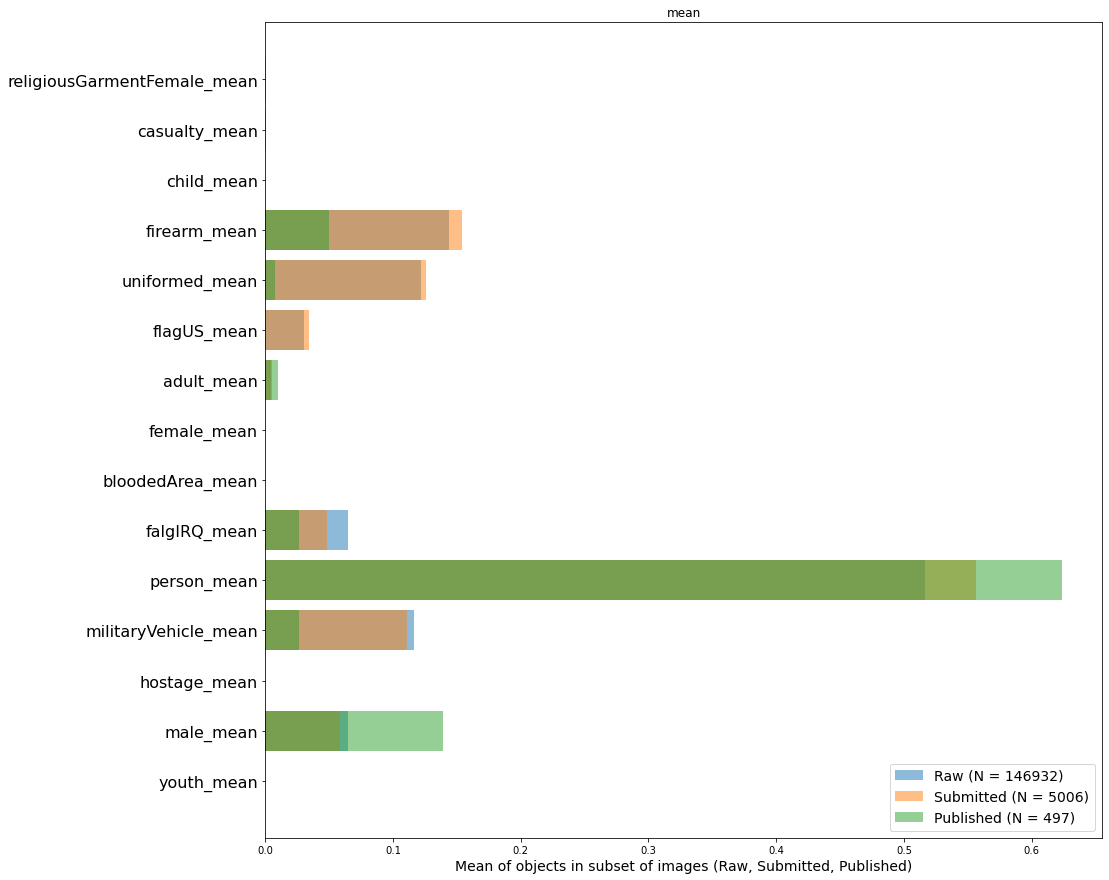

In [53]:
for t in np.arange(0.1, 0.55, 0.05):

    df_name = f'df_t{int(t*100)}'
    df = df_dict[df_name]

    feature_dist_plots(df, 'dummy')

UnboundLocalError: local variable 'N' referenced before assignment

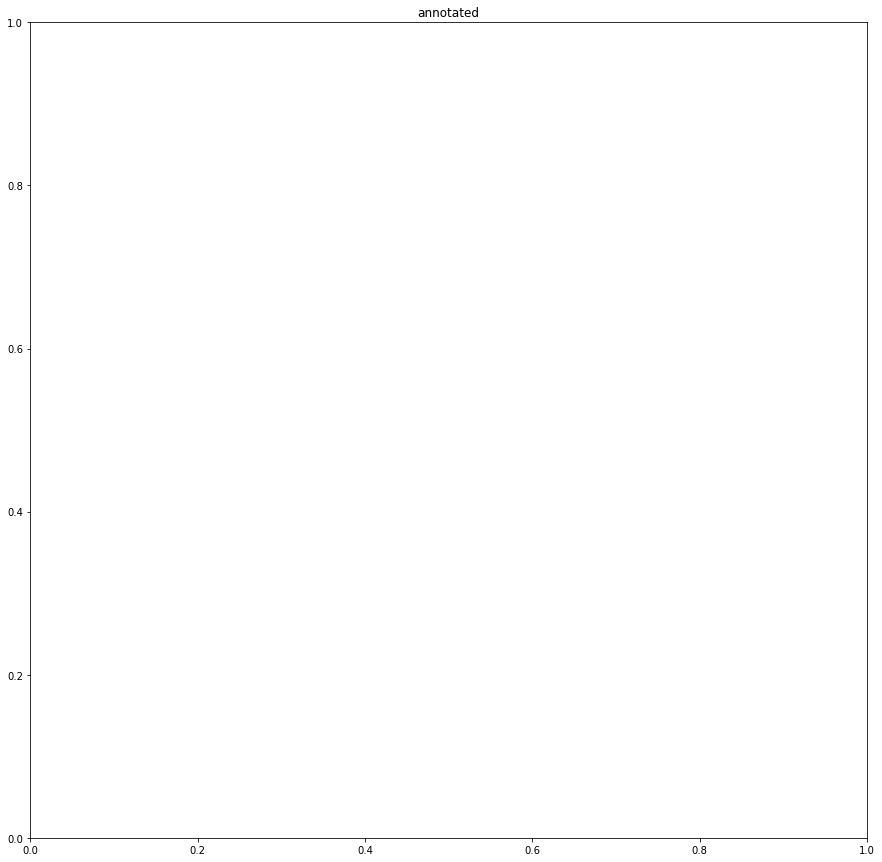

In [9]:
t = 0.1
#t = 0.5

df_name = f'df_t{int(t*100)}'
df = df_dict[df_name]

# feature_version_list = ['annotated', 'mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50']
feature_version_list = ['annotated', 'mean']

for i in feature_version_list:
    feature_dist_plots(df, i)

In [5]:
#df_sub = df.sample(5000)

plotting child: both. Dim: (1007, 151)


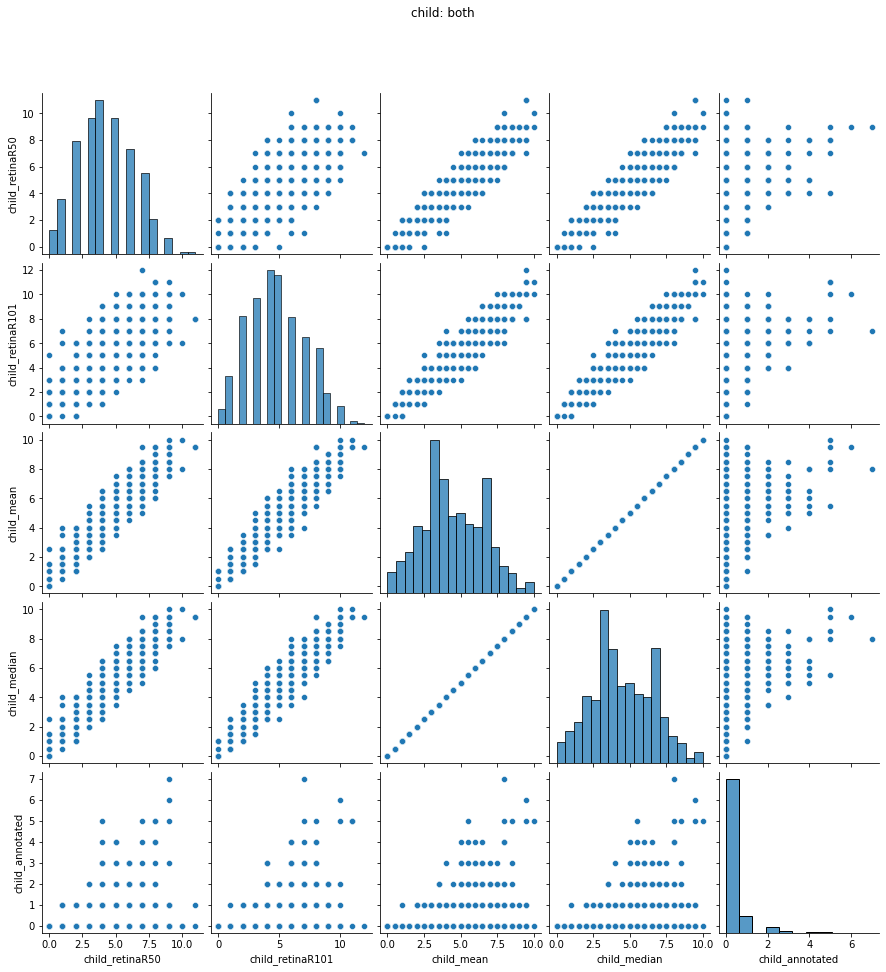

plotting uniformed: both. Dim: (1007, 151)


KeyboardInterrupt: 

In [16]:
plot_corr(df)

In [ ]:
feature_version_list = ['annotated', 'mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50']
for i in feature_version_list:
    feature_dist_plots(df, i)

# OLD:

# remember: 
All thresholds were set at 0.1 in prediction scripts.  

> cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold

If everything is over estimated, lower it. But this you can also do model specific! Seem like it is mostly ratinanet that overestimates.. Number, but on the flip side it is way better at rare objects! As should be expected.
- In theory you shoould be abel to just use the instance object and create a new output_list.pkl and all_img_feature_list wiht a lower threshold for "score"

# testing:

## Important to do:
- Also think about doing the last ratina net also 
- and maybe not including the fasterRCNN in rare cases (or some other rule)
    - Right now stuff gets fucked up when the Faster's esitmate only zeores..


- Ok... the "overestimation" due to threshold is kind of irretating now.. But how to decide on that abitrary number? 
    - actually - you do have the socers savd so you maybe you could just do asomething there?


# FULL
Todo:
- Make sure meta works here
- Explore...


# final:+
The generation of the dfs should be in their own script. Not here.
Make both annotated_df and df as pickles.



# TWO MAIN ISSUES RIGHT NOW:
1) 0.1 threshold is too high for Retina. Can you fix it from you data or do you need to run new models?
2) What should be the critaria for including models for ensamble? Or should they be weigted?
(need to fix 1 beofre I can survey 2...)


In [ ]:
## You should just load the dfs here.
# with open('spanner_annotated_df.pkl', 'wb') as file:
#     pickle.dump(annotated_df, file)

annotated_df = annotate_df()
annotated_df = meta_to_df(annotated_df)

annotated_df.sample(10)

In [ ]:
np.corrcoef(annotated_df['person_fasterR50'], annotated_df['person_annotated'])

In [ ]:
# Plotting

plot_corr(annotated_df)
plot_corr(annotated_df, 'train')
plot_corr(annotated_df, 'test')

feature_version_list = ['annotated', 'mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50']
for i in feature_version_list:
    feature_dist_plots(annotated_df, i)

# Annotated, alt threshold (0.3):

In [ ]:
# try w/ alt threshold:
annotated_df_t30 = annotate_df(alt_threshold= True)
annotated_df_t30 = meta_to_df(annotated_df_t30)

annotated_df_t30.sample(10)

In [ ]:
annotated_df_t30['img_id'].head() == annotated_df['img_id'].head()

In [ ]:
np.corrcoef(annotated_df_t30['person_fasterR50'], annotated_df_t30['person_annotated'])

In [ ]:
plot_corr(annotated_df_t30)
plot_corr(annotated_df_t30, 'train')
plot_corr(annotated_df_t30, 'test')

feature_version_list = ['annotated', 'mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50']
for i in feature_version_list:
    feature_dist_plots(annotated_df_t30, i)

## Important to do:

- After this you could implement FULL before handling the threshold issue described below..
- Also think about doing the last ratina net also - and meybe not including the fasterRCNN in rare cats (or some other rule)
    - Right now stuff gets fucked upi when the Faster's esitmate only zeores..

- Ok... the "overestimation" due to threshold is kind of irretating now.. But how to decide on that abitrary number? 
    - actually - you do have the socers savd so you maybe you could just do asomething there?
    Else, look at parameter below and run again.
    > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold in prediction.py....

# FULL

In [ ]:
df = annotate_df(FULL = True)


In [ ]:
df = meta_to_df(df, img_dir='/media/simon/Seagate Expansion Drive/images_spanner')

Aprox 830min or 14hours

In [ ]:
df.shape

In [ ]:
#with open('spanner_full_df.pkl', 'wb') as file:
  #  pickle.dump(df, file)

In [ ]:
df.sample(10)

In [ ]:
df['custom2'].unique()

In [ ]:
n_raw = (df['custom2'] == 'Raw').sum()
n_sub = (df['custom2'] == 'Submitted').sum()
n_pub = (df['custom2'] == 'Published').sum()

for i in [('Raw', n_raw), ('Submitted', n_sub), ('Published', n_pub)]:
    print(f'Number of {i[0]}: {i[1]} \n')

## Test pickle:


In [ ]:

with open('spanner_full_df.pkl', 'rb') as file:
        test_pickle_df = pickle.load(file)

print(test_pickle_df.shape)
print(test_pickle_df['custom2'].unique())

tp_n_raw = (test_pickle_df['custom2'] == 'Raw').sum()
tp_n_sub = (test_pickle_df['custom2'] == 'Submitted').sum()
tp_n_pub = (test_pickle_df['custom2'] == 'Published').sum()

for i in [('Raw', tp_n_raw), ('Submitted', tp_n_sub), ('Published', tp_n_pub)]:
    print(f'Number of {i[0]}: {i[1]} \n')

In [ ]:
test_pickle_df.sample(10)

Seems good.

# Corrolation plots

In [ ]:
sub_df = df.sample(1000) # subset to plot

In [ ]:
plot_corr(sub_df)

# Raw, Sub an Pub

In [ ]:
# you of course do not have meta yet ...
feature_version_list = ['mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50'] # no annotaated
for i in feature_version_list:
    feature_dist_plots(df, i) # but this is with full df.. Not the subset for scatter plot